# Manually Selection of the Most Likely Causal Genes from Significant TWAS Genes

## Aim

Genomewide MR was skipped due to missing `MAF` column in the imputed GWAS sumstats, and our [TWAS pipeline](https://github.com/rl3328/xqtl-protocol/blob/main/code/pecotmr_integration/twas_ctwas.ipynb) runs TWAS and MR in the same step (`twas`). This notebook serves as a quick rescue to manually diminish noise from LD hitchhiking and identify the most likely causal genes.



## Steps

### 1. Filter genes qualified for MR analysis

Most thresholds follow the default requirements in \[`twas`], except I use a stricter `twas_pval` cutoff. The reason is that I want to directly apply the filter to “significant” TWAS genes in my manuscript while also saving resources.

**Criteria:**

1. Strong and reliable TWAS signals:

   * `twas_pval < 2.5*1e-6`
   * `rsq_cv > 0.01`
   * `rsq_pval < 0.05`
2. Strong GWAS signals:

   * Have `CS`, which can be extracted from `twas_weight(.rds)` files

### 2. Manually select the most likely causal gene

Within each LD block and by context, I define the gene with the strongest GWAS signal as follows:

* For each gene–context combination:

  * If no credible set (CS) is available, skip (this corresponds to filtering step 1.2).
  * If a 95% CS exists, select the gene containing the variant with the highest PIP within the 95% CS. If not, fall back to 70% CS.
  * If a 70% CS exists, select the gene containing the variant with the highest PIP within the 70% CS. If not, fall back to 50% CS.
  * If a 50% CS exists, select the gene containing the variant with the highest PIP within the 50% CS.



## Note

There are some differences between this identification and the [loose gene list](https://github.com/rl3328/xqtl-analysis/blob/main/production/image_QTL/interested_genes/TWAS_QTL/loose_gene/image_AD2_gene_list.tsv).

* Loose list: 42 genes, filtered by `is_selected_method` and `twas_pval < 2.5*1e-6`
* Current identification: 443 genes are strong TWAS genes(twas_pval < 2.5*1e-6 & rsq_cv > 0.01 & pval_cv < 0.05) for AD2 and Knight cohort, 48 genes were identified as the final list.



## Input

1. **Merged TWAS results** (`*.twas.tsv.gz`):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/rl3328/image_QTL/twas/image_AD2_twas_merged.tsv.gz.combined_twas.tsv.gz`
2. **xQTL\_meta\_file** (meta file specifying TWAS weight paths by cohort):

   * `s3://statfungen/ftp_fgc_xqtl/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv`


## Plan

Other GWAS studies and other cohorts will be analyzed in the same way.


In [1]:
library(data.table)
library(tidyverse)
library(pecotmr)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.2     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::between()     masks data.table::between()
✖ dplyr::filter()      masks stats::filter()
✖ dplyr::first()       masks data.table::first()
✖ lubridate::hour()    masks data.table::hour()
✖ lubridate::isoweek() masks data.table::isoweek()
✖ dplyr::lag()         masks stats::lag()
✖ dplyr::last()        masks data.table::last()
✖ lubridate::mday()    masks data.table::mday()
✖ lubridate::minute()  masks data.table::minute()
✖ lubridate::month()   masks data.table::month()
✖ lubridate::quarter() masks data.table::quarter()
✖ lubridate::second()  masks data.table::second()
✖ purrr::transpose()   masks data.table::transpose()
✖ lubridate::wday() 

In [2]:
setwd("~/data")

In [3]:
##Bonfferroni correction is too strict
# AD2_twas = fread("~/project/image_QTL/twas/multiple_testing/image_AD2_twas_bonff.bonf_corrected.tsv.gz")


In [4]:
AD2_twas = fread("~/project/image_QTL/twas/image_AD2_twas_merged.tsv.gz.combined_twas.tsv.gz")


In [11]:
weight_db_list = fread("~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv")
# weight_db_list = fread("~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv")


In [6]:
# No gene presents in multiple blocks
genes_in_multiple_blocks <- AD2_twas %>% group_by(molecular_id) %>% summarise(
    number_of_blocks = n_distinct(block)) %>%
    filter(number_of_blocks > 1)

print(genes_in_multiple_blocks)

# A tibble: 0 × 2
# ℹ 2 variables: molecular_id <chr>, number_of_blocks <int>


In [6]:
head(AD2_twas)
dim(AD2_twas)

chr,molecular_id,TSS,start,end,context,gwas_study,method,is_imputable,is_selected_method,rsq_cv,pval_cv,twas_z,twas_pval,type,block,region,study_context,source_file
<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,<chr>,<lgl>,<lgl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,enet,TRUE,FALSE,0.098757440,8.923911e-10,2.492697,0.01267771,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,lasso,TRUE,FALSE,0.103370596,3.541036e-10,2.475217,0.01331554,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,mrash,TRUE,FALSE,0.089177838,6.013310e-09,2.493315,0.01265565,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000055950,100987514,99320000,102120000,Knight_eQTL_brain,image_AD2,susie,TRUE,TRUE,0.121638427,8.766557e-12,2.505183,0.01223882,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_AD2,enet,TRUE,FALSE,0.007872702,5.201216e-02,1.830248,0.06721286,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz
10,ENSG00000059915,102421538,101402617,103680000,Knight_eQTL_brain,image_AD2,lasso,TRUE,FALSE,0.006195072,7.447581e-02,1.827701,0.06759438,eQTL,chr10_100331627_104378781,chr10_100331627_104378781,KNIGHT_eQTL_pQTL,KNIGHT_eQTL_pQTL.chr10_100331627_104378781.twas.tsv.gz


[1] 903842     19

In [10]:
str(MSBB)

ERROR: Error: object 'MSBB' not found


In [7]:
# Strong and reliable TWAS signals:
AD2_twas_filtered <- AD2_twas |>
    filter(
        twas_pval < 2.5*1e-6 &     # Stricter p-value threshold 
        rsq_cv > 0.01 &          # Cross-validation R²
        pval_cv < 0.05          # R² significance
    )
AD2_block = unique(AD2_twas_filtered$block)

In [8]:
dim(AD2_twas_filtered)

[1] 817  19

In [15]:
# R Script to Process TWAS/SuSiE Fine-mapping Results and Match with GWAS
# Extracts variants in credible sets and identifies top GWAS variant per gene-context-cohort

# Step 1: Load necessary libraries
library(purrr)
library(stringr)
library(data.table)
library(dplyr)

# --- Helper Function for CS Variant Selection (No PIP filtering) ---
select_all_cs_variants <- function(df, gene_id) {
    # Select ALL variants that are in any credible set (coverage > 0 at any level)
    # No PIP filtering - just get CS membership
    
    if (nrow(df) == 0) {
        warning(paste("No variants found for gene:", gene_id))
        return(NULL)
    }
    
    # Validate required columns
    required_cols <- c("cs_coverage_0.95", "cs_coverage_0.7", "cs_coverage_0.5")
    missing_cols <- setdiff(required_cols, colnames(df))
    if (length(missing_cols) > 0) {
        warning(paste("Gene", gene_id, ": Missing required columns:", paste(missing_cols, collapse = ", ")))
        return(NULL)
    }
    
    # Select ALL variants that are in ANY credible set (any coverage > 0)
    cs_variants <- df |> 
        filter(cs_coverage_0.95 > 0 | cs_coverage_0.7 > 0 | cs_coverage_0.5 > 0)
    
    if (nrow(cs_variants) == 0) {
        warning(paste("Gene", gene_id, ": No variants with credible set coverage > 0"))
        return(NULL)
    }
    
    # Determine highest coverage level for each variant
    cs_variants <- cs_variants |>
        mutate(
            highest_cs_level = case_when(
                cs_coverage_0.95 > 0 ~ "cs_0.95",
                cs_coverage_0.7 > 0 ~ "cs_0.7",
                cs_coverage_0.5 > 0 ~ "cs_0.5",
                TRUE ~ "none"
            )
        )
    
    message(paste("Gene", gene_id, ": Selected", nrow(cs_variants), "variants in credible sets"))
    
    return(cs_variants)
}

# --- Define Cohort Information ---
cohorts <- list(
    KNIGHT = list(
        name = "KNIGHT",
        weight_db_path = "~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv"
    ),
    MSBB = list(
        name = "MSBB", 
        weight_db_path = "~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv"
    ),
    ROSMAP = list(
        name = "ROSMAP",
        weight_db_path = "~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv"
    ),
    ROSMAP_MEGA = list(
        name = "ROSMAP_MEGA",
        weight_db_path = "~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv"
    )
)

# --- Load GWAS Metadata ---
gwas_meta_path <- "~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD2/image_AD2_gwas_meta_by_chrom.tsv"
cat("Loading GWAS metadata from:", gwas_meta_path, "\n")
gwas_meta <- fread(gwas_meta_path)
cat(sprintf("Loaded GWAS metadata for %d chromosomes\n", nrow(gwas_meta)))

# Create a lookup for GWAS files by chromosome
gwas_files_by_chrom <- setNames(
    paste0("~/data/", gwas_meta$file_path),
    gwas_meta$chrom
)

# --- Function to Load GWAS Data for Specific Chromosome ---
load_gwas_for_chrom <- function(chrom, gwas_lookup) {
    if (!as.character(chrom) %in% names(gwas_lookup)) {
        warning(paste("No GWAS file found for chromosome:", chrom))
        return(NULL)
    }
    
    gwas_file <- gwas_lookup[[as.character(chrom)]]
    cat(sprintf("  Loading GWAS data for chr%s from: %s\n", chrom, gwas_file))
    
    tryCatch({
        # Load GWAS data
        gwas_data <- fread(gwas_file, select = c("variant_id", "z", "P"))
        
        # Calculate p-value from Z-score if P column is missing or NA
        if (!"P" %in% colnames(gwas_data) || all(is.na(gwas_data$P))) {
            cat("    Calculating p-values from Z-scores\n")
            gwas_data$P <- 2 * pnorm(-abs(gwas_data$z))
        }
        
        # Remove variants with missing p-values
        gwas_data <- gwas_data |> filter(!is.na(P))
        
        cat(sprintf("    Loaded %d variants with valid p-values for chr%s\n", 
                   nrow(gwas_data), chrom))
        return(gwas_data)
    }, error = function(e) {
        warning(paste("Error loading GWAS file for chr", chrom, ":", e$message))
        return(NULL)
    })
}

# --- Main Processing Logic ---

# Initialize master list to store results from all cohorts
all_cohorts_results <- list()
master_processing_summary <- list(
    cohorts_processed = 0,
    total_genes_processed = 0,
    genes_with_cs = 0,
    genes_with_gwas_match = 0,
    total_cs_variants = 0,
    total_matched_variants = 0,
    errors = character(0)
)

cat("=== Starting Multi-Cohort TWAS/SuSiE Processing with GWAS Integration ===\n")
cat("Cohorts to process:", length(cohorts), "\n")
cat("Total regions per cohort:", length(AD2_block), "\n\n")

# Loop through each cohort
for (cohort_idx in seq_along(cohorts)) {
    cohort_info <- cohorts[[cohort_idx]]
    cohort_name <- cohort_info$name
    weight_db_path <- cohort_info$weight_db_path
    
    cat(sprintf("=== PROCESSING COHORT %d/%d: %s ===\n", cohort_idx, length(cohorts), cohort_name))
    
    # Initialize cohort-specific tracking
    cohort_results <- list()
    
    tryCatch({
        # Load weight database list for current cohort
        cat(sprintf("Loading weight database metadata: %s\n", weight_db_path))
        weight_db_list <- fread(weight_db_path)
        cat(sprintf("Loaded %d weight database entries for %s\n", nrow(weight_db_list), cohort_name))
        
        master_processing_summary$cohorts_processed <- master_processing_summary$cohorts_processed + 1
        
        # Loop through each specified region/block
        for (region_idx in seq_along(AD2_block)) {
            region_db <- AD2_block[region_idx]
            
            cat(sprintf("  Processing region %d/%d: %s\n", region_idx, length(AD2_block), region_db))
            
            tryCatch({
                # Filter for significant genes within the current block
                AD2_multigene_per_block <- AD2_twas_filtered |> 
                    filter(block == region_db)
                
                contexts_in_region <- unique(AD2_multigene_per_block$context)
                
                cat(sprintf("    Found genes across %d contexts in region %s\n", 
                           length(contexts_in_region), region_db))
                
                if (length(contexts_in_region) == 0) {
                    cat("    No contexts found, skipping region\n")
                    next
                }
                
                # Loop through each context in the region
                for (context_name in contexts_in_region) {
                    cat(sprintf("      Processing context: %s\n", context_name))
                    
                    # Filter for genes in this specific context
                    genes_in_context <- AD2_multigene_per_block |> 
                        filter(context == context_name) |> 
                        pull(molecular_id) |> 
                        unique()
                    
                    cat(sprintf("        %d genes in this context\n", length(genes_in_context)))
                    
                    # Loop through each gene in the current context
                    for (gene_idx in seq_along(genes_in_context)) {
                        gene_db <- genes_in_context[gene_idx]
                        master_processing_summary$total_genes_processed <- 
                            master_processing_summary$total_genes_processed + 1
                        
                        cat(sprintf("          Processing gene %d/%d: %s\n", 
                                   gene_idx, length(genes_in_context), gene_db))
                        
                        tryCatch({
                            # Get the database paths for the weights
                            weight_db_matches <- weight_db_list |> filter(region_id == gene_db)
                            
                            if (nrow(weight_db_matches) == 0) {
                                next
                            }
                            
                            weight_dbs <- weight_db_matches |> 
                                pull(original_data) |> 
                                str_split(",") |> 
                                unlist()
                            
                            # Load the weights for the current gene
                            twas_weights_results <- load_twas_weights(
                                weight_dbs, 
                                variable_name_obj = "variant_names", 
                                susie_obj = "susie_weights_intermediate",
                                twas_weights_table = "twas_weights"
                            )
                            
                            # Validate results
                            if (!is.list(twas_weights_results) || 
                                is.null(twas_weights_results$susie_results) ||
                                length(twas_weights_results$susie_results) == 0) {
                                next
                            }
                            
                            susie_res <- twas_weights_results$susie_results[[1]]
                            
                            if (is.null(susie_res$top_loci) || nrow(susie_res$top_loci) == 0) {
                                next
                            }
                            
                            df <- as.data.frame(susie_res$top_loci)
                            
                            # Use CS selection function to get ALL CS variants
                            gene_context_cohort_id <- paste(gene_db, context_name, cohort_name, sep = "_")
                            cs_variants_df <- select_all_cs_variants(df, gene_context_cohort_id)
                            
                            if (is.null(cs_variants_df) || nrow(cs_variants_df) == 0) {
                                next
                            }
                            
                            master_processing_summary$genes_with_cs <- 
                                master_processing_summary$genes_with_cs + 1
                            master_processing_summary$total_cs_variants <- 
                                master_processing_summary$total_cs_variants + nrow(cs_variants_df)
                            
                            # Extract chromosome from variant_id (first element before ':')
                            # Remove "chr" prefix to match GWAS format
                            cs_variants_df$variant_id_gwas <- gsub("^chr", "", cs_variants_df$variant_id)
                            cs_variants_df$chrom <- sapply(strsplit(cs_variants_df$variant_id_gwas, ":"), `[`, 1)
                            
                            # Get unique chromosomes in this gene's CS variants
                            unique_chroms <- unique(cs_variants_df$chrom)
                            cat(sprintf("            Found CS variants on chromosomes: %s\n", 
                                       paste(unique_chroms, collapse = ", ")))
                            
                            # Load GWAS data for each chromosome and match variants
                            gwas_matched_variants <- list()
                            
                            for (chrom in unique_chroms) {
                                gwas_data <- load_gwas_for_chrom(chrom, gwas_files_by_chrom)
                                
                                if (is.null(gwas_data)) {
                                    next
                                }
                                
                                # Filter CS variants for this chromosome
                                cs_variants_chrom <- cs_variants_df |> filter(chrom == !!chrom)
                                
                                # Match with GWAS data using the modified variant_id (without "chr")
                                matched <- cs_variants_chrom |>
                                    inner_join(gwas_data, by = c("variant_id_gwas" = "variant_id"))
                                
                                if (nrow(matched) > 0) {
                                    gwas_matched_variants[[as.character(chrom)]] <- matched
                                    cat(sprintf("              Chr%s: Matched %d/%d CS variants with GWAS\n",
                                               chrom, nrow(matched), nrow(cs_variants_chrom)))
                                }
                            }
                            
                            # Combine all matched variants across chromosomes
                            if (length(gwas_matched_variants) == 0) {
                                cat("            No GWAS matches found for any CS variants\n")
                                next
                            }
                            
                            all_matched <- bind_rows(gwas_matched_variants)
                            master_processing_summary$total_matched_variants <- 
                                master_processing_summary$total_matched_variants + nrow(all_matched)
                            
                            # Select variant with smallest GWAS p-value
                            top_variant <- all_matched |>
                                arrange(P) |>
                                slice(1)
                            
                            # Add metadata
                            top_variant$gene_id <- gene_db
                            top_variant$block_id <- region_db
                            top_variant$context <- context_name
                            top_variant$cohort <- cohort_name
                            top_variant$n_cs_variants <- nrow(cs_variants_df)
                            top_variant$n_matched_variants <- nrow(all_matched)
                            
                            # Create unique key for gene-context-cohort combination
                            unique_key <- paste(gene_db, context_name, cohort_name, sep = "_")
                            
                            # Store the result
                            cohort_results[[unique_key]] <- top_variant
                            master_processing_summary$genes_with_gwas_match <- 
                                master_processing_summary$genes_with_gwas_match + 1
                            
                            cat(sprintf("            ✓ Top variant: %s (P=%.2e) for gene %s\n", 
                                       top_variant$variant_id, top_variant$P, gene_db))
                            
                        }, error = function(e) {
                            error_msg <- paste("Gene", gene_db, "context", context_name, 
                                             "cohort", cohort_name, "error:", e$message)
                            master_processing_summary$errors <- 
                                c(master_processing_summary$errors, error_msg)
                        })
                    }
                }
                
            }, error = function(e) {
                error_msg <- paste("Region", region_db, "cohort", cohort_name, "error:", e$message)
                master_processing_summary$errors <- c(master_processing_summary$errors, error_msg)
            })
        }
        
        # Store cohort results
        all_cohorts_results[[cohort_name]] <- cohort_results
        
        cat(sprintf("  Completed cohort %s: %d genes with GWAS-matched top variants\n\n", 
                   cohort_name, length(cohort_results)))
        
    }, error = function(e) {
        error_msg <- paste("Cohort", cohort_name, "error:", e$message)
        master_processing_summary$errors <- c(master_processing_summary$errors, error_msg)
    })
}

# --- Final Results Compilation ---
cat("=== PROCESSING SUMMARY ===\n")
cat("Total gene-context-cohort combinations processed:", 
    master_processing_summary$total_genes_processed, "\n")
cat("Combinations with credible sets:", master_processing_summary$genes_with_cs, "\n")
cat("Combinations with GWAS-matched top variant:", 
    master_processing_summary$genes_with_gwas_match, "\n")
cat("Total CS variants across all combinations:", 
    master_processing_summary$total_cs_variants, "\n")
cat("Total CS variants matched with GWAS:", 
    master_processing_summary$total_matched_variants, "\n")

# Flatten all cohort results into final data frame
all_results_flattened <- list()
for (cohort_name in names(all_cohorts_results)) {
    cohort_data <- all_cohorts_results[[cohort_name]]
    all_results_flattened <- c(all_results_flattened, cohort_data)
}

final_df <- bind_rows(all_results_flattened)

if (nrow(final_df) > 0) {
    cat(sprintf("\n=== FINAL RESULTS ===\n"))
    cat(sprintf("Created data frame with %d top GWAS variants (one per gene-context-cohort)\n", 
               nrow(final_df)))
    
    # Select final columns
    final_df <- final_df |>
        select(
            variant_id_qtl = variant_id,
            variant_id_gwas,
            chrom,
            gene_id,
            context,
            cohort,
            block_id,
            gwas_p = P,
            gwas_z = z,
            betahat,
            sebetahat,
            highest_cs_level,
            n_cs_variants,
            n_matched_variants
        )
    
    # Summary statistics
    cat("\nSummary by cohort:\n")
    cohort_summary <- final_df |>
        group_by(cohort) |>
        summarise(
            n_genes = n(),
            median_gwas_p = median(gwas_p),
            mean_cs_variants = mean(n_cs_variants),
            .groups = "drop"
        )
    print(cohort_summary)
    
    cat("\nSummary by context:\n")
    context_summary <- final_df |>
        group_by(context) |>
        summarise(
            n_genes = n(),
            median_gwas_p = median(gwas_p),
            .groups = "drop"
        )
    print(context_summary)
    
    cat("\n=== SAMPLE RESULTS (first 10 rows) ===\n")
    print(head(final_df, 10))
    
    cat("\n=== Top 10 most significant GWAS variants ===\n")
    print(final_df |> arrange(gwas_p) |> head(10))
    
} else {
    cat("\n=== NO RESULTS ===\n")
    cat("No top variants identified. Check errors above.\n")
}

Loading GWAS metadata from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_gwas_meta_by_chrom.tsv 
Loaded GWAS metadata for 22 chromosomes
=== Starting Multi-Cohort TWAS/SuSiE Processing with GWAS Integration ===
Cohorts to process: 4 
Total regions per cohort: 38 

=== PROCESSING COHORT 1/4: KNIGHT ===
Loading weight database metadata: ~/data/interactive_analysis/cl4215/KNIGHT_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv
Loaded 16852 weight database entries for KNIGHT
  Processing region 1/38: chr12_115165608_117668628
    Found genes across 18 contexts in region chr12_115165608_117668628
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_Knight_eQTL_brain_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_10_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_22_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_36_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_44_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989
      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_KNIGHT : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 12/19 CS variants with GWAS
            ✓ Top variant: chr12:117444295:A:G (P=2.16e-01) for gene ENSG00000089250
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_AC_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135119


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_AC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000174989
      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_DLPFC_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989
      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_Exc_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135108


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135108_Exc_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000174989
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_PCC_DeJager_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992


Gene ENSG00000088992_Exc_mega_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr12:117047727:A:G (P=3.05e-01) for gene ENSG00000088992
          Processing gene 2/4: ENSG00000135108


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135108_Exc_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 3/4: ENSG00000135119


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_Exc_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 4/4: ENSG00000174989
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989
  Processing region 2/38: chr12_61991992_65677087
    Found genes across 13 contexts in region chr12_61991992_65677087
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000153179


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000153179_Knight_eQTL_brain_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000174106


Gene ENSG00000174106_Knight_eQTL_brain_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 28/34 CS variants with GWAS
            ✓ Top variant: chr12:65201398:C:G (P=1.26e-01) for gene ENSG00000174106
          Processing gene 3/3: ENSG00000184575
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106


Gene ENSG00000174106_BM_36_MSBB_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 28/34 CS variants with GWAS
            ✓ Top variant: chr12:65201398:C:G (P=1.26e-01) for gene ENSG00000174106
          Processing gene 2/2: ENSG00000183735
      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490


Gene ENSG00000111490_AC_DeJager_eQTL_KNIGHT : Selected 7 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 2/7 CS variants with GWAS
            ✓ Top variant: chr12:64944247:A:G (P=1.55e-02) for gene ENSG00000111490
          Processing gene 2/3: ENSG00000174106


Gene ENSG00000174106_AC_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 28/34 CS variants with GWAS
            ✓ Top variant: chr12:65201398:C:G (P=1.26e-01) for gene ENSG00000174106
          Processing gene 3/3: ENSG00000288591


Gene ENSG00000288591_AC_DeJager_eQTL_KNIGHT : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 3/9 CS variants with GWAS
            ✓ Top variant: chr12:64944247:A:G (P=1.55e-02) for gene ENSG00000288591
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 28/34 CS variants with GWAS
            ✓ Top variant: chr12:65201398:C:G (P=1.26e-01) for gene ENSG00000174106
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_DLPFC_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 28/34 CS variants with GWAS
            ✓ Top variant: chr12:65201398:C:G (P=1.26e-01) for gene ENSG00000174106
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Exc_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 28/34 CS variants with GWAS
            ✓ Top variant: chr12:65201398:C:G (P=1.26e-01) for gene ENSG00000174106
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Inh_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 28/34 CS variants with GWAS
            ✓ Top variant: chr12:65201398:C:G (P=1.26e-01) for gene ENSG00000174106
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Oli_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 28/34 CS variants with GWAS
            ✓ Top variant: chr12:65201398:C:G (P=1.26e-01) for gene ENSG00000174106
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_PCC_DeJager_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 28/34 CS variants with GWAS
            ✓ Top variant: chr12:65201398:C:G (P=1.26e-01) for gene ENSG00000174106
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099


Gene ENSG00000174099_Exc_mega_eQTL_KNIGHT : Selected 51 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 51/51 CS variants with GWAS
            ✓ Top variant: chr12:65452451:C:T (P=1.03e-04) for gene ENSG00000174099
          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_Exc_mega_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 28/34 CS variants with GWAS
            ✓ Top variant: chr12:65201398:C:G (P=1.26e-01) for gene ENSG00000174106
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174099


Gene ENSG00000174099_Inh_mega_eQTL_KNIGHT : Selected 51 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 51/51 CS variants with GWAS
            ✓ Top variant: chr12:65452451:C:T (P=1.03e-04) for gene ENSG00000174099
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_mega_eQTL_KNIGHT : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 28/34 CS variants with GWAS
            ✓ Top variant: chr12:65201398:C:G (P=1.26e-01) for gene ENSG00000174106
  Processing region 3/38: chr12_65677087_66254548
    Found genes across 1 contexts in region chr12_65677087_66254548
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000228144


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000228144_Knight_eQTL_brain_KNIGHT : No variants with credible set coverage > 0”


  Processing region 4/38: chr20_32060775_36429279
    Found genes across 7 contexts in region chr20_32060775_36429279
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000125965
          Processing gene 2/2: ENSG00000126001


Gene ENSG00000126001_Knight_eQTL_brain_KNIGHT : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000025293
          Processing gene 2/3: ENSG00000125965
          Processing gene 3/3: ENSG00000126001


Gene ENSG00000126001_BM_36_MSBB_eQTL_KNIGHT : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000101019


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000101019_BM_44_MSBB_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 2/4: ENSG00000125965
          Processing gene 3/4: ENSG00000125991


Gene ENSG00000125991_BM_44_MSBB_eQTL_KNIGHT : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 17/17 CS variants with GWAS
            ✓ Top variant: chr20:35537487:T:C (P=1.38e-01) for gene ENSG00000125991
          Processing gene 4/4: ENSG00000126001


Gene ENSG00000126001_BM_44_MSBB_eQTL_KNIGHT : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000125965
          Processing gene 2/3: ENSG00000125991


Gene ENSG00000125991_BM_10_MSBB_eQTL_KNIGHT : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 17/17 CS variants with GWAS
            ✓ Top variant: chr20:35537487:T:C (P=1.38e-01) for gene ENSG00000125991
          Processing gene 3/3: ENSG00000126001


Gene ENSG00000126001_BM_10_MSBB_eQTL_KNIGHT : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000125965
          Processing gene 2/2: ENSG00000125966


Gene ENSG00000125966_BM_22_MSBB_eQTL_KNIGHT : Selected 75 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 49/75 CS variants with GWAS
            ✓ Top variant: chr20:34893114:G:C (P=7.85e-02) for gene ENSG00000125966
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126001


Gene ENSG00000126001_AC_DeJager_eQTL_KNIGHT : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000244005
  Processing region 5/38: chr2_231326994_233100399
    Found genes across 1 contexts in region chr2_231326994_233100399
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000171551


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000171551_Knight_eQTL_brain_KNIGHT : No variants with credible set coverage > 0”


  Processing region 6/38: chr6_26341332_28390030
    Found genes across 16 contexts in region chr6_26341332_28390030
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000096654


Gene ENSG00000096654_Knight_eQTL_brain_KNIGHT : Selected 94 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 92/94 CS variants with GWAS
            ✓ Top variant: chr6:26387318:C:T (P=1.19e-02) for gene ENSG00000096654
          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_Knight_eQTL_brain_KNIGHT : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 11/11 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000276302


Gene ENSG00000276302_Knight_eQTL_brain_KNIGHT : Selected 14 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 14/14 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000276302
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000111801


Gene ENSG00000111801_BM_22_MSBB_eQTL_KNIGHT : Selected 193 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 166/193 CS variants with GWAS
            ✓ Top variant: chr6:27891675:T:C (P=6.47e-04) for gene ENSG00000111801
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000189298


Gene ENSG00000189298_BM_10_MSBB_eQTL_KNIGHT : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 11/11 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000276302


Gene ENSG00000276302_BM_44_MSBB_eQTL_KNIGHT : Selected 14 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 14/14 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000276302
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000198315


Gene ENSG00000198315_Inh_DeJager_eQTL_KNIGHT : Selected 155 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 152/155 CS variants with GWAS
            ✓ Top variant: chr6:28138363:T:C (P=2.75e-02) for gene ENSG00000198315
          Processing gene 2/2: ENSG00000197062
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000275126
          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_AC_DeJager_eQTL_KNIGHT : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 11/11 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000276302


Gene ENSG00000276302_AC_DeJager_eQTL_KNIGHT : Selected 14 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 14/14 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000276302
      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000187626
          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_DLPFC_DeJager_eQTL_KNIGHT : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 11/11 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000197062
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000189298


Gene ENSG00000189298_PCC_DeJager_eQTL_KNIGHT : Selected 11 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 11/11 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 2/2: ENSG00000276302


Gene ENSG00000276302_PCC_DeJager_eQTL_KNIGHT : Selected 14 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 14/14 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000276302
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197062
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000235109


Gene ENSG00000235109_Exc_DeJager_eQTL_KNIGHT : Selected 257 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 140/257 CS variants with GWAS
            ✓ Top variant: chr6:28054945:C:A (P=1.84e-02) for gene ENSG00000235109
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Ast_mega_eQTL_KNIGHT : Selected 155 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 152/155 CS variants with GWAS
            ✓ Top variant: chr6:28138363:T:C (P=2.75e-02) for gene ENSG00000198315
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Exc_mega_eQTL_KNIGHT : Selected 155 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 152/155 CS variants with GWAS
            ✓ Top variant: chr6:28138363:T:C (P=2.75e-02) for gene ENSG00000198315
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Inh_mega_eQTL_KNIGHT : Selected 155 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 152/155 CS variants with GWAS
            ✓ Top variant: chr6:28138363:T:C (P=2.75e-02) for gene ENSG00000198315
      Processing context: ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763
        1 genes in this context
          Processing gene 1/1: ENSG00000112763


Gene ENSG00000112763_ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763_KNIGHT : Selected 113 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 112/113 CS variants with GWAS
            ✓ Top variant: chr6:26387318:C:T (P=1.19e-02) for gene ENSG00000112763
      Processing context: ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315
        1 genes in this context
          Processing gene 1/1: ENSG00000181315


Gene ENSG00000181315_ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315_KNIGHT : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 27/27 CS variants with GWAS
            ✓ Top variant: chr6:26656976:T:C (P=6.04e-01) for gene ENSG00000181315
      Processing context: ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
        1 genes in this context
          Processing gene 1/1: ENSG00000187626
  Processing region 7/38: chr6_28390030_30136357
    Found genes across 2 contexts in region chr6_28390030_30136357
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197935


Gene ENSG00000197935_Knight_eQTL_brain_KNIGHT : Selected 345 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 322/345 CS variants with GWAS
            ✓ Top variant: chr6:29376618:C:T (P=1.02e-02) for gene ENSG00000197935
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187987


Gene ENSG00000187987_BM_44_MSBB_eQTL_KNIGHT : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr6:28440481:A:G (P=1.21e-01) for gene ENSG00000187987
  Processing region 8/38: chr6_30136357_31604117
    Found genes across 7 contexts in region chr6_30136357_31604117
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000234127


Gene ENSG00000234127_Knight_eQTL_brain_KNIGHT : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 17/17 CS variants with GWAS
            ✓ Top variant: chr6:30204050:T:C (P=8.65e-02) for gene ENSG00000234127
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127


Gene ENSG00000234127_AC_DeJager_eQTL_KNIGHT : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 17/17 CS variants with GWAS
            ✓ Top variant: chr6:30204050:T:C (P=8.65e-02) for gene ENSG00000234127
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000234127


Gene ENSG00000234127_DLPFC_DeJager_eQTL_KNIGHT : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 17/17 CS variants with GWAS
            ✓ Top variant: chr6:30204050:T:C (P=8.65e-02) for gene ENSG00000234127
          Processing gene 2/2: ENSG00000146112
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127


Gene ENSG00000234127_PCC_DeJager_eQTL_KNIGHT : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 17/17 CS variants with GWAS
            ✓ Top variant: chr6:30204050:T:C (P=8.65e-02) for gene ENSG00000234127
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137331
      Processing context: DLPFC_Bennett_pQTL_chr6_Q5ST30
        1 genes in this context
          Processing gene 1/1: ENSG00000137411


Gene ENSG00000137411_DLPFC_Bennett_pQTL_chr6_Q5ST30_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 47/60 CS variants with GWAS
            ✓ Top variant: chr6:30915079:A:G (P=1.06e-01) for gene ENSG00000137411
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137312


Gene ENSG00000137312_Oli_mega_eQTL_KNIGHT : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
            No GWAS matches found for any CS variants
  Processing region 9/38: chr11_44270671_46916060
    Found genes across 4 contexts in region chr11_44270671_46916060
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
  Processing region 10/38: chr12_56408332_59603125
    Found genes across 1 context

Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000166886_MSBB_BM36_pQTL_chr12_Q15742_KNIGHT : No variants with credible set coverage > 0”


  Processing region 11/38: chr17_42087601_45383525
    Found genes across 22 contexts in region chr17_42087601_45383525
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176563


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000176563_BM_44_MSBB_eQTL_KNIGHT : No variants with credible set coverage > 0”


      Processing context: MSBB_BM36_pQTL_chr17_Q14562
        1 genes in this context
          Processing gene 1/1: ENSG00000067596


Gene ENSG00000067596_MSBB_BM36_pQTL_chr17_Q14562_KNIGHT : Selected 12 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 12/12 CS variants with GWAS
            ✓ Top variant: chr17:43455779:C:T (P=1.12e-01) for gene ENSG00000067596
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108828
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000175906
          Processing gene 2/3: ENSG00000136448
          Processing gene 3/3: ENSG00000161714


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000161714_BM_36_MSBB_eQTL_KNIGHT : No variants with credible set coverage > 0”


      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000005961
          Processing gene 2/3: ENSG00000141349
          Processing gene 3/3: ENSG00000006062
      Processing context: MSBB_BM36_pQTL_chr17_Q59EK9-2
        1 genes in this context
          Processing gene 1/1: ENSG00000108309
      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PPA3
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PS58
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
      Processing context: MSBB_BM36_pQTL_chr17_K7EPI4
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
      Processing context: MSBB_BM36_pQTL_chr17_K7EPT8
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
      Processing context: DLPFC_Bennett_pQTL_chr17_P23258
        1 genes in this context
          Processing

Gene ENSG00000131462_DLPFC_Bennett_pQTL_chr17_P23258_KNIGHT : Selected 69 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 68/69 CS variants with GWAS
            ✓ Top variant: chr17:42666433:G:A (P=1.03e-02) for gene ENSG00000131462
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000141699
          Processing gene 2/3: ENSG00000266967
          Processing gene 3/3: ENSG00000186834


Gene ENSG00000186834_PCC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr17:45920912:C:T (P=5.56e-01) for gene ENSG00000186834
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000012048


Gene ENSG00000012048_Oli_DeJager_eQTL_KNIGHT : Selected 261 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 232/261 CS variants with GWAS
            ✓ Top variant: chr17:43020464:G:T (P=6.86e-02) for gene ENSG00000012048
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000012048


Gene ENSG00000012048_monocyte_ROSMAP_eQTL_KNIGHT : Selected 261 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 232/261 CS variants with GWAS
            ✓ Top variant: chr17:43020464:G:T (P=6.86e-02) for gene ENSG00000012048
          Processing gene 2/3: ENSG00000108861
          Processing gene 3/3: ENSG00000186834


Gene ENSG00000186834_monocyte_ROSMAP_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr17:45920912:C:T (P=5.56e-01) for gene ENSG00000186834
      Processing context: DLPFC_Bennett_pQTL_chr17_Q14168
        1 genes in this context
          Processing gene 1/1: ENSG00000108852


Gene ENSG00000108852_DLPFC_Bennett_pQTL_chr17_Q14168_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr17:43875439:G:A (P=7.79e-01) for gene ENSG00000108852
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000236383
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161682
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000131094


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000131094_DLPFC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000136448
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161714


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000161714_AC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000037042


Gene ENSG00000037042_Ast_mega_eQTL_KNIGHT : Selected 61 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 61/61 CS variants with GWAS
            ✓ Top variant: chr17:42564502:A:G (P=1.47e-02) for gene ENSG00000037042
          Processing gene 2/2: ENSG00000136448
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108840


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000108840_Exc_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000136448
      Processing context: OPC_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136448
  Processing region 12/38: chr17_45383525_50162864
    Found genes across 20 contexts in region chr17_45383525_50162864
      Processing context: BM_10_MSBB_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071


Gene ENSG00000120071_BM_10_MSBB_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/5: ENSG00000185829


Gene ENSG00000185829_BM_10_MSBB_eQTL_KNIGHT : Selected 1825 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 175/1825 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/5: ENSG00000228696


Gene ENSG00000228696_BM_10_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 4/8 CS variants with GWAS
            ✓ Top variant: chr17:46212466:A:G (P=1.21e-03) for gene ENSG00000228696
          Processing gene 4/5: ENSG00000238083


Gene ENSG00000238083_BM_10_MSBB_eQTL_KNIGHT : Selected 1311 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 56/1311 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000238083
          Processing gene 5/5: ENSG00000256762
      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071


Gene ENSG00000120071_BM_22_MSBB_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/4: ENSG00000185829


Gene ENSG00000185829_BM_22_MSBB_eQTL_KNIGHT : Selected 1825 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 175/1825 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/4: ENSG00000228696


Gene ENSG00000228696_BM_22_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 4/8 CS variants with GWAS
            ✓ Top variant: chr17:46212466:A:G (P=1.21e-03) for gene ENSG00000228696
          Processing gene 4/4: ENSG00000238083


Gene ENSG00000238083_BM_22_MSBB_eQTL_KNIGHT : Selected 1311 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 56/1311 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000238083
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_BM_36_MSBB_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000185829


Gene ENSG00000185829_BM_36_MSBB_eQTL_KNIGHT : Selected 1825 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 175/1825 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/3: ENSG00000228696


Gene ENSG00000228696_BM_36_MSBB_eQTL_KNIGHT : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 4/8 CS variants with GWAS
            ✓ Top variant: chr17:46212466:A:G (P=1.21e-03) for gene ENSG00000228696
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_BM_44_MSBB_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000185829


Gene ENSG00000185829_BM_44_MSBB_eQTL_KNIGHT : Selected 1825 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 175/1825 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_AC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000120088


Gene ENSG00000120088_AC_DeJager_eQTL_KNIGHT : Selected 1821 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 179/1821 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000120088
          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_AC_DeJager_eQTL_KNIGHT : Selected 1825 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 175/1825 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071


Gene ENSG00000120071_Ast_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/4: ENSG00000176681


Gene ENSG00000176681_Ast_DeJager_eQTL_KNIGHT : Selected 1314 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 54/1314 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000176681
          Processing gene 3/4: ENSG00000186868


Gene ENSG00000186868_Ast_DeJager_eQTL_KNIGHT : Selected 2092 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 320/2092 CS variants with GWAS
            ✓ Top variant: chr17:46785767:T:C (P=2.68e-05) for gene ENSG00000186868
          Processing gene 4/4: ENSG00000238083


Gene ENSG00000238083_Ast_DeJager_eQTL_KNIGHT : Selected 1311 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 56/1311 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000238083
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_DLPFC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000073969


Gene ENSG00000073969_DLPFC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Exc_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_Inh_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000225190
      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_Mic_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_Mic_DeJager_eQTL_KNIGHT : Selected 1311 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 56/1311 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000238083
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_OPC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_OPC_DeJager_eQTL_KNIGHT : Selected 1311 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 56/1311 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000238083
      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071


Gene ENSG00000120071_Oli_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/5: ENSG00000120088


Gene ENSG00000120088_Oli_DeJager_eQTL_KNIGHT : Selected 1821 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 179/1821 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000120088
          Processing gene 3/5: ENSG00000176681


Gene ENSG00000176681_Oli_DeJager_eQTL_KNIGHT : Selected 1314 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 54/1314 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000176681
          Processing gene 4/5: ENSG00000238083


Gene ENSG00000238083_Oli_DeJager_eQTL_KNIGHT : Selected 1311 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 56/1311 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000238083
          Processing gene 5/5: ENSG00000073969


Gene ENSG00000073969_Oli_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_PCC_DeJager_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000185294


Gene ENSG00000185294_PCC_DeJager_eQTL_KNIGHT : Selected 1676 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 171/1676 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000185294
          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_PCC_DeJager_eQTL_KNIGHT : Selected 1825 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 175/1825 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_monocyte_ROSMAP_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000176681


Gene ENSG00000176681_monocyte_ROSMAP_eQTL_KNIGHT : Selected 1314 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 54/1314 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000176681
          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_monocyte_ROSMAP_eQTL_KNIGHT : Selected 1825 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 175/1825 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: Mic_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000073969


Gene ENSG00000073969_Mic_mega_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000120071


Gene ENSG00000120071_Mic_mega_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
      Processing context: Oli_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000073969


Gene ENSG00000073969_Oli_mega_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/3: ENSG00000120071


Gene ENSG00000120071_Oli_mega_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 3/3: ENSG00000238083


Gene ENSG00000238083_Oli_mega_eQTL_KNIGHT : Selected 1311 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 56/1311 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000238083
      Processing context: Ast_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_Ast_mega_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000225190
          Processing gene 3/3: ENSG00000238083


Gene ENSG00000238083_Ast_mega_eQTL_KNIGHT : Selected 1311 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 56/1311 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000238083
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Exc_mega_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Inh_mega_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_OPC_mega_eQTL_KNIGHT : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr17:46044213:T:C (P=3.57e-02) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_OPC_mega_eQTL_KNIGHT : Selected 1311 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 56/1311 CS variants with GWAS
            ✓ Top variant: chr17:46112790:T:C (P=6.02e-05) for gene ENSG00000238083
  Processing region 13/38: chr1_22020160_24199848
    Found genes across 9 contexts in region chr1_22020160_24199848
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_10_MSBB_eQTL_KNIGHT : Selected 79 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 73/79 CS variants with GWAS
            ✓ Top variant: chr1:23478162:C:T (P=1.05e-01) for gene ENSG00000204219
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_22_MSBB_eQTL_KNIGHT : Selected 79 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 73/79 CS variants with GWAS
            ✓ Top variant: chr1:23478162:C:T (P=1.05e-01) for gene ENSG00000204219
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_36_MSBB_eQTL_KNIGHT : Selected 79 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 73/79 CS variants with GWAS
            ✓ Top variant: chr1:23478162:C:T (P=1.05e-01) for gene ENSG00000204219
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_44_MSBB_eQTL_KNIGHT : Selected 79 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 73/79 CS variants with GWAS
            ✓ Top variant: chr1:23478162:C:T (P=1.05e-01) for gene ENSG00000204219
      Processing context: DLPFC_Bennett_pQTL_chr1_Q8TDY4
        1 genes in this context
          Processing gene 1/1: ENSG00000088280


Gene ENSG00000088280_DLPFC_Bennett_pQTL_chr1_Q8TDY4_KNIGHT : Selected 13 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 12/13 CS variants with GWAS
            ✓ Top variant: chr1:23478162:C:T (P=1.05e-01) for gene ENSG00000088280
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_AC_DeJager_eQTL_KNIGHT : Selected 79 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 73/79 CS variants with GWAS
            ✓ Top variant: chr1:23478162:C:T (P=1.05e-01) for gene ENSG00000204219
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_DLPFC_DeJager_eQTL_KNIGHT : Selected 79 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 73/79 CS variants with GWAS
            ✓ Top variant: chr1:23478162:C:T (P=1.05e-01) for gene ENSG00000204219
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_Inh_DeJager_eQTL_KNIGHT : Selected 79 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 73/79 CS variants with GWAS
            ✓ Top variant: chr1:23478162:C:T (P=1.05e-01) for gene ENSG00000204219
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_PCC_DeJager_eQTL_KNIGHT : Selected 79 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 73/79 CS variants with GWAS
            ✓ Top variant: chr1:23478162:C:T (P=1.05e-01) for gene ENSG00000204219
  Processing region 14/38: chr2_218398735_221656890
    Found genes across 12 contexts in region chr2_218398735_221656890
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Gene ENSG00000115556_BM_10_MSBB_eQTL_KNIGHT : Selected 59 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 55/59 CS variants with GWAS
            ✓ Top variant: chr2:218522550:C:G (P=1.65e-01) for gene ENSG00000115556
          Processing gene 2/2: ENSG00000144580


Gene ENSG00000144580_BM_10_MSBB_eQTL_KNIGHT : Selected 296 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 218/296 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580


Gene ENSG00000144580_BM_44_MSBB_eQTL_KNIGHT : Selected 296 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 218/296 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115556


Gene ENSG00000115556_DLPFC_DeJager_eQTL_KNIGHT : Selected 59 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 55/59 CS variants with GWAS
            ✓ Top variant: chr2:218522550:C:G (P=1.65e-01) for gene ENSG00000115556
      Processing context: Exc_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Gene ENSG00000115556_Exc_DeJager_eQTL_KNIGHT : Selected 59 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 55/59 CS variants with GWAS
            ✓ Top variant: chr2:218522550:C:G (P=1.65e-01) for gene ENSG00000115556
          Processing gene 2/2: ENSG00000144580


Gene ENSG00000144580_Exc_DeJager_eQTL_KNIGHT : Selected 296 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 218/296 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: PCC_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000115556


Gene ENSG00000115556_PCC_DeJager_eQTL_KNIGHT : Selected 59 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 55/59 CS variants with GWAS
            ✓ Top variant: chr2:218522550:C:G (P=1.65e-01) for gene ENSG00000115556
          Processing gene 2/4: ENSG00000135913
          Processing gene 3/4: ENSG00000144580


Gene ENSG00000144580_PCC_DeJager_eQTL_KNIGHT : Selected 296 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 218/296 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
          Processing gene 4/4: ENSG00000072195


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000072195_PCC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000115568


Gene ENSG00000115568_AC_DeJager_eQTL_KNIGHT : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
            No GWAS matches found for any CS variants
          Processing gene 2/3: ENSG00000135912


Gene ENSG00000135912_AC_DeJager_eQTL_KNIGHT : Selected 121 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 105/121 CS variants with GWAS
            ✓ Top variant: chr2:216157566:G:GGCT (P=2.66e-01) for gene ENSG00000135912
          Processing gene 3/3: ENSG00000135913
      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115592
          Processing gene 2/2: ENSG00000144580


Gene ENSG00000144580_monocyte_ROSMAP_eQTL_KNIGHT : Selected 296 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 218/296 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580


Gene ENSG00000144580_Inh_DeJager_eQTL_KNIGHT : Selected 296 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 218/296 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Gene ENSG00000115556_Inh_mega_eQTL_KNIGHT : Selected 59 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 55/59 CS variants with GWAS
            ✓ Top variant: chr2:218522550:C:G (P=1.65e-01) for gene ENSG00000115556
          Processing gene 2/2: ENSG00000144580


Gene ENSG00000144580_Inh_mega_eQTL_KNIGHT : Selected 296 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 218/296 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580


Gene ENSG00000144580_Ast_mega_eQTL_KNIGHT : Selected 296 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 218/296 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
  Processing region 15/38: chr3_99631497_103307790
    Found genes across 1 contexts in region chr3_99631497_103307790
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000168386


Gene ENSG00000168386_BM_10_MSBB_eQTL_KNIGHT : Selected 48 variants in credible sets



            Found CS variants on chromosomes: 3
  Loading GWAS data for chr3 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.3.tsv.gz
    Loaded 373263 variants with valid p-values for chr3
              Chr3: Matched 48/48 CS variants with GWAS
            ✓ Top variant: chr3:99801747:G:A (P=3.39e-01) for gene ENSG00000168386
  Processing region 16/38: chr6_24583576_26341332
    Found genes across 1 contexts in region chr6_24583576_26341332
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000278463


Gene ENSG00000278463_BM_44_MSBB_eQTL_KNIGHT : Selected 47 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 34/47 CS variants with GWAS
            ✓ Top variant: chr6:26242549:G:C (P=4.19e-01) for gene ENSG00000278463
  Processing region 17/38: chr6_31604117_32714947
    Found genes across 5 contexts in region chr6_31604117_32714947
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435
          Processing gene 2/3: ENSG00000224389


Gene ENSG00000224389_BM_10_MSBB_eQTL_KNIGHT : Selected 183 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 172/183 CS variants with GWAS
            ✓ Top variant: chr6:32454931:T:C (P=6.88e-02) for gene ENSG00000224389
          Processing gene 3/3: ENSG00000244731


Gene ENSG00000244731_BM_10_MSBB_eQTL_KNIGHT : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr6:31973120:A:G (P=1.62e-01) for gene ENSG00000244731
      Processing context: BM_22_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435
          Processing gene 2/3: ENSG00000204421


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000204421_BM_22_MSBB_eQTL_KNIGHT : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000244731


Gene ENSG00000244731_BM_22_MSBB_eQTL_KNIGHT : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr6:31973120:A:G (P=1.62e-01) for gene ENSG00000244731
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000204435
          Processing gene 2/2: ENSG00000244731


Gene ENSG00000244731_BM_36_MSBB_eQTL_KNIGHT : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr6:31973120:A:G (P=1.62e-01) for gene ENSG00000244731
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000204435
          Processing gene 2/4: ENSG00000224389


Gene ENSG00000224389_BM_44_MSBB_eQTL_KNIGHT : Selected 183 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 172/183 CS variants with GWAS
            ✓ Top variant: chr6:32454931:T:C (P=6.88e-02) for gene ENSG00000224389
          Processing gene 3/4: ENSG00000244731


Gene ENSG00000244731_BM_44_MSBB_eQTL_KNIGHT : Selected 50 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 47/50 CS variants with GWAS
            ✓ Top variant: chr6:31973120:A:G (P=1.62e-01) for gene ENSG00000244731
          Processing gene 4/4: ENSG00000213676


Gene ENSG00000213676_BM_44_MSBB_eQTL_KNIGHT : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
            No GWAS matches found for any CS variants
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204410
  Processing region 18/38: chr7_114072332_117140445
    Found genes across 1 contexts in region chr7_114072332_117140445
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135269


Gene ENSG00000135269_BM_36_MSBB_eQTL_KNIGHT : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 306052 variants with valid p-values for chr7
              Chr7: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr7:116211123:G:A (P=4.69e-01) for gene ENSG00000135269
  Processing region 19/38: chr11_110348807_112120989
    Found genes across 1 contexts in region chr11_110348807_112120989
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000150776
  Processing region 20/38: chr11_46916060_49936088
    Found genes across 4 contexts in region chr11_46916060_49936088
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Exc_DeJager_eQTL_KNIGHT : Selected 47 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 3/47 CS variants with GWAS
            ✓ Top variant: chr11:46912709:C:G (P=5.86e-01) for gene ENSG00000149179
      Processing context: DLPFC_Bennett_pQTL_chr11_Q9UKS6
        1 genes in this context
          Processing gene 1/1: ENSG00000165912


Gene ENSG00000165912_DLPFC_Bennett_pQTL_chr11_Q9UKS6_KNIGHT : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
            No GWAS matches found for any CS variants
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Exc_mega_eQTL_KNIGHT : Selected 47 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 3/47 CS variants with GWAS
            ✓ Top variant: chr11:46912709:C:G (P=5.86e-01) for gene ENSG00000149179
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Inh_mega_eQTL_KNIGHT : Selected 47 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 3/47 CS variants with GWAS
            ✓ Top variant: chr11:46912709:C:G (P=5.86e-01) for gene ENSG00000149179
  Processing region 21/38: chr11_60339997_63818332
    Found genes across 1 contexts in region chr11_60339997_63818332
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110108


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000110108_AC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


  Processing region 22/38: chr16_29685831_46381513
    Found genes across 2 contexts in region chr16_29685831_46381513
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102886


Gene ENSG00000102886_DLPFC_DeJager_eQTL_KNIGHT : Selected 27 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 146250 variants with valid p-values for chr16
              Chr16: Matched 16/27 CS variants with GWAS
            ✓ Top variant: chr16:30319567:T:C (P=2.62e-02) for gene ENSG00000102886
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102882
  Processing region 23/38: chr17_81070897_83242554
    Found genes across 1 contexts in region chr17_81070897_83242554
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176155


Gene ENSG00000176155_Inh_DeJager_eQTL_KNIGHT : Selected 32 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 14/32 CS variants with GWAS
            ✓ Top variant: chr17:82218044:C:T (P=7.71e-01) for gene ENSG00000176155
  Processing region 24/38: chr1_16103_2888443
    Found genes across 1 contexts in region chr1_16103_2888443
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197785
  Processing region 25/38: chr1_165222465_167670072
    Found genes across 4 contexts in region chr1_165222465_167670072
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Ast_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166969318:T:C (P=1.37e-03) for gene ENSG00000143194
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166969318:T:C (P=1.37e-03) for gene ENSG00000143194
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Inh_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166969318:T:C (P=1.37e-03) for gene ENSG00000143194
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_PCC_DeJager_eQTL_KNIGHT : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 59/60 CS variants with GWAS
            ✓ Top variant: chr1:166969318:T:C (P=1.37e-03) for gene ENSG00000143194
  Processing region 26/38: chr2_160577800_163745636
    Found genes across 1 contexts in region chr2_160577800_163745636
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000136560_AC_DeJager_eQTL_KNIGHT : No variants with credible set coverage > 0”


  Processing region 27/38: chr2_201677542_203951659
    Found genes across 1 contexts in region chr2_201677542_203951659
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000138380


Gene ENSG00000138380_Mic_DeJager_eQTL_KNIGHT : Selected 23 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 2/23 CS variants with GWAS
            ✓ Top variant: chr2:202966073:A:C (P=3.54e-01) for gene ENSG00000138380
  Processing region 28/38: chr2_53613086_54460117
    Found genes across 2 contexts in region chr2_53613086_54460117
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306


Gene ENSG00000115306_AC_DeJager_eQTL_KNIGHT : Selected 13 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 6/13 CS variants with GWAS
            ✓ Top variant: chr2:54467674:C:T (P=1.28e-03) for gene ENSG00000115306
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306


Gene ENSG00000115306_Ast_DeJager_eQTL_KNIGHT : Selected 13 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 6/13 CS variants with GWAS
            ✓ Top variant: chr2:54467674:C:T (P=1.28e-03) for gene ENSG00000115306
  Processing region 29/38: chr5_149895776_152257891
    Found genes across 1 contexts in region chr5_149895776_152257891
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901
  Processing region 30/38: chr5_156029821_157766573
    Found genes across 1 contexts in region chr5_156029821_157766573
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000055163


Gene ENSG00000055163_AC_DeJager_eQTL_KNIGHT : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 5
  Loading GWAS data for chr5 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.5.tsv.gz
    Loaded 345041 variants with valid p-values for chr5
              Chr5: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr5:155410929:A:G (P=6.49e-01) for gene ENSG00000055163
  Processing region 31/38: chr5_66304871_68440323
    Found genes across 2 contexts in region chr5_66304871_68440323
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020


Gene ENSG00000069020_Oli_DeJager_eQTL_KNIGHT : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 5
  Loading GWAS data for chr5 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.5.tsv.gz
    Loaded 345041 variants with valid p-values for chr5
              Chr5: Matched 11/20 CS variants with GWAS
            ✓ Top variant: chr5:66687385:T:A (P=3.59e-01) for gene ENSG00000069020
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020


Gene ENSG00000069020_Oli_mega_eQTL_KNIGHT : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 5
  Loading GWAS data for chr5 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.5.tsv.gz
    Loaded 345041 variants with valid p-values for chr5
              Chr5: Matched 11/20 CS variants with GWAS
            ✓ Top variant: chr5:66687385:T:A (P=3.59e-01) for gene ENSG00000069020
  Processing region 32/38: chr6_10464625_11911817
    Found genes across 9 contexts in region chr6_10464625_11911817
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269

Gene ENSG00000066651_Ast_DeJager_eQTL_KNIGHT : Selected 43 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 41/43 CS variants with GWAS
            ✓ Top variant: chr6:125982039:C:G (P=2.32e-01) for gene ENSG00000066651
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Gene ENSG00000066651_Exc_DeJager_eQTL_KNIGHT : Selected 43 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 41/43 CS variants with GWAS
            ✓ Top variant: chr6:125982039:C:G (P=2.32e-01) for gene ENSG00000066651
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Gene ENSG00000066651_Inh_DeJager_eQTL_KNIGHT : Selected 43 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 41/43 CS variants with GWAS
            ✓ Top variant: chr6:125982039:C:G (P=2.32e-01) for gene ENSG00000066651
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Gene ENSG00000066651_Oli_DeJager_eQTL_KNIGHT : Selected 43 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 41/43 CS variants with GWAS
            ✓ Top variant: chr6:125982039:C:G (P=2.32e-01) for gene ENSG00000066651
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Gene ENSG00000066651_Ast_mega_eQTL_KNIGHT : Selected 43 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 41/43 CS variants with GWAS
            ✓ Top variant: chr6:125982039:C:G (P=2.32e-01) for gene ENSG00000066651
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Gene ENSG00000066651_Exc_mega_eQTL_KNIGHT : Selected 43 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 41/43 CS variants with GWAS
            ✓ Top variant: chr6:125982039:C:G (P=2.32e-01) for gene ENSG00000066651
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Gene ENSG00000066651_Inh_mega_eQTL_KNIGHT : Selected 43 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 41/43 CS variants with GWAS
            ✓ Top variant: chr6:125982039:C:G (P=2.32e-01) for gene ENSG00000066651
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Gene ENSG00000066651_Oli_mega_eQTL_KNIGHT : Selected 43 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 41/43 CS variants with GWAS
            ✓ Top variant: chr6:125982039:C:G (P=2.32e-01) for gene ENSG00000066651
  Processing region 34/38: chr1_50179506_54277735
    Found genes across 1 contexts in region chr1_50179506_54277735
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185104


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000185104_Oli_mega_eQTL_KNIGHT : No variants with credible set coverage > 0”


  Processing region 35/38: chr4_102190604_104971820
    Found genes across 2 contexts in region chr4_102190604_104971820
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109323
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109332
  Processing region 36/38: chr8_10429394_11231445
    Found genes across 1 contexts in region chr8_10429394_11231445
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000254093
          Processing gene 2/2: ENSG00000258724
  Processing region 37/38: chr9_87677148_89739207
    Found genes across 1 contexts in region chr9_87677148_89739207
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187764


Gene ENSG00000187764_Ast_mega_eQTL_KNIGHT : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 9
  Loading GWAS data for chr9 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.9.tsv.gz
    Loaded 221580 variants with valid p-values for chr9
              Chr9: Matched 5/6 CS variants with GWAS
            ✓ Top variant: chr9:89483114:G:A (P=8.61e-01) for gene ENSG00000187764
  Processing region 38/38: chr13_35472583_36923754
    Found genes across 1 contexts in region chr13_35472583_36923754
      Processing context: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
        1 genes in this context
          Processing gene 1/1: ENSG00000250709


Gene ENSG00000250709_ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709_KNIGHT : Selected 256 variants in credible sets



            Found CS variants on chromosomes: 13
  Loading GWAS data for chr13 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.13.tsv.gz
    Loaded 196381 variants with valid p-values for chr13
              Chr13: Matched 255/256 CS variants with GWAS
            ✓ Top variant: chr13:36249628:C:T (P=4.28e-01) for gene ENSG00000250709
  Completed cohort KNIGHT: 167 genes with GWAS-matched top variants

=== PROCESSING COHORT 2/4: MSBB ===
Loading weight database metadata: ~/project/image_QTL/twas/MSBB_eQTL_pQTL_twas_wgw_xqtl_meta_data.tsv
Loaded 17466 weight database entries for MSBB
  Processing region 1/38: chr12_115165608_117668628
    Found genes across 18 contexts in region chr12_115165608_117668628
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_Knight_eQTL_brain_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_10_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_22_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_22_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_36_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_36_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_44_MSBB_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr12:117455126:G:A (P=2.93e-01) for gene ENSG00000089250
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_AC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135119


list twas_weights is not found in ENSG00000135119.  




          Processing gene 3/3: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_DLPFC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_DLPFC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_Exc_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135108


list twas_weights is not found in ENSG00000135108.  




          Processing gene 3/3: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_PCC_DeJager_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Oli_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_monocyte_ROSMAP_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992


Gene ENSG00000088992_Exc_mega_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr12:117039728:C:T (P=5.80e-01) for gene ENSG00000088992
          Processing gene 2/4: ENSG00000135108


list twas_weights is not found in ENSG00000135108.  




          Processing gene 3/4: ENSG00000135119


list twas_weights is not found in ENSG00000135119.  




          Processing gene 4/4: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Exc_mega_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Inh_mega_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Mic_mega_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174989_Oli_mega_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 2/38: chr12_61991992_65677087
    Found genes across 13 contexts in region chr12_61991992_65677087
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000153179


list twas_weights is not found in ENSG00000153179.  




          Processing gene 2/3: ENSG00000174106
          Processing gene 3/3: ENSG00000184575
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106
          Processing gene 2/2: ENSG00000183735


list twas_weights is not found in ENSG00000183735.  




      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490


Gene ENSG00000111490_AC_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
          Processing gene 2/3: ENSG00000174106
          Processing gene 3/3: ENSG00000288591


Gene ENSG00000288591_AC_DeJager_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/2 CS variants with GWAS
            ✓ Top variant: chr12:64883750:A:T (P=9.80e-01) for gene ENSG00000288591
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG

Gene ENSG00000228144_Knight_eQTL_brain_MSBB : Selected 12 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/12 CS variants with GWAS
            ✓ Top variant: chr12:66092543:A:G (P=4.78e-01) for gene ENSG00000228144
  Processing region 4/38: chr20_32060775_36429279
    Found genes across 7 contexts in region chr20_32060775_36429279
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000125965


Gene ENSG00000125965_Knight_eQTL_brain_MSBB : Selected 61 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 3/61 CS variants with GWAS
            ✓ Top variant: chr20:35315833:C:T (P=6.15e-07) for gene ENSG00000125965
          Processing gene 2/2: ENSG00000126001


Gene ENSG00000126001_Knight_eQTL_brain_MSBB : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000025293


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000025293_BM_36_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000125965


Gene ENSG00000125965_BM_36_MSBB_eQTL_MSBB : Selected 61 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 3/61 CS variants with GWAS
            ✓ Top variant: chr20:35315833:C:T (P=6.15e-07) for gene ENSG00000125965
          Processing gene 3/3: ENSG00000126001


Gene ENSG00000126001_BM_36_MSBB_eQTL_MSBB : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000101019
          Processing gene 2/4: ENSG00000125965


Gene ENSG00000125965_BM_44_MSBB_eQTL_MSBB : Selected 61 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 3/61 CS variants with GWAS
            ✓ Top variant: chr20:35315833:C:T (P=6.15e-07) for gene ENSG00000125965
          Processing gene 3/4: ENSG00000125991
          Processing gene 4/4: ENSG00000126001


Gene ENSG00000126001_BM_44_MSBB_eQTL_MSBB : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000125965


Gene ENSG00000125965_BM_10_MSBB_eQTL_MSBB : Selected 61 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 3/61 CS variants with GWAS
            ✓ Top variant: chr20:35315833:C:T (P=6.15e-07) for gene ENSG00000125965
          Processing gene 2/3: ENSG00000125991
          Processing gene 3/3: ENSG00000126001


Gene ENSG00000126001_BM_10_MSBB_eQTL_MSBB : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000125965


Gene ENSG00000125965_BM_22_MSBB_eQTL_MSBB : Selected 61 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 3/61 CS variants with GWAS
            ✓ Top variant: chr20:35315833:C:T (P=6.15e-07) for gene ENSG00000125965
          Processing gene 2/2: ENSG00000125966
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126001


Gene ENSG00000126001_AC_DeJager_eQTL_MSBB : Selected 33 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000244005


Gene ENSG00000244005_Ast_DeJager_eQTL_MSBB : Selected 61 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 61/61 CS variants with GWAS
            ✓ Top variant: chr20:35764523:G:A (P=4.58e-04) for gene ENSG00000244005
  Processing region 5/38: chr2_231326994_233100399
    Found genes across 1 contexts in region chr2_231326994_233100399
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000171551


list twas_weights is not found in ENSG00000171551.  




  Processing region 6/38: chr6_26341332_28390030
    Found genes across 16 contexts in region chr6_26341332_28390030
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000096654
          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_Knight_eQTL_brain_MSBB : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000276302


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000276302_Knight_eQTL_brain_MSBB : No variants with credible set coverage > 0”


      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000111801


Gene ENSG00000111801_BM_22_MSBB_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
            No GWAS matches found for any CS variants
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000189298


Gene ENSG00000189298_BM_10_MSBB_eQTL_MSBB : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000276302


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000276302_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000198315


Gene ENSG00000198315_Inh_DeJager_eQTL_MSBB : Selected 71 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 70/71 CS variants with GWAS
            ✓ Top variant: chr6:28070115:G:T (P=3.79e-02) for gene ENSG00000198315
          Processing gene 2/2: ENSG00000197062
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000275126
          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_AC_DeJager_eQTL_MSBB : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000276302


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000276302_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000187626


list twas_weights is not found in ENSG00000187626.  




          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_DLPFC_DeJager_eQTL_MSBB : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000197062
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000189298


Gene ENSG00000189298_PCC_DeJager_eQTL_MSBB : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 2/2: ENSG00000276302


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000276302_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197062
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000235109


Gene ENSG00000235109_Exc_DeJager_eQTL_MSBB : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 2/6 CS variants with GWAS
            ✓ Top variant: chr6:28356620:T:C (P=5.78e-02) for gene ENSG00000235109
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Ast_mega_eQTL_MSBB : Selected 71 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 70/71 CS variants with GWAS
            ✓ Top variant: chr6:28070115:G:T (P=3.79e-02) for gene ENSG00000198315
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Exc_mega_eQTL_MSBB : Selected 71 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 70/71 CS variants with GWAS
            ✓ Top variant: chr6:28070115:G:T (P=3.79e-02) for gene ENSG00000198315
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Inh_mega_eQTL_MSBB : Selected 71 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 70/71 CS variants with GWAS
            ✓ Top variant: chr6:28070115:G:T (P=3.79e-02) for gene ENSG00000198315
      Processing context: ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763
        1 genes in this context
          Processing gene 1/1: ENSG00000112763
      Processing context: ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315
        1 genes in this context
          Processing gene 1/1: ENSG00000181315


Gene ENSG00000181315_ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315_MSBB : Selected 40 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 14/40 CS variants with GWAS
            ✓ Top variant: chr6:26614995:G:A (P=1.66e-01) for gene ENSG00000181315
      Processing context: ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
        1 genes in this context
          Processing gene 1/1: ENSG00000187626


list twas_weights is not found in ENSG00000187626.  




  Processing region 7/38: chr6_28390030_30136357
    Found genes across 2 contexts in region chr6_28390030_30136357
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197935
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187987


Gene ENSG00000187987_BM_44_MSBB_eQTL_MSBB : Selected 36 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 32/36 CS variants with GWAS
            ✓ Top variant: chr6:28440481:A:G (P=1.21e-01) for gene ENSG00000187987
  Processing region 8/38: chr6_30136357_31604117
    Found genes across 7 contexts in region chr6_30136357_31604117
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000234127


Gene ENSG00000234127_Knight_eQTL_brain_MSBB : Selected 49 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 43/49 CS variants with GWAS
            ✓ Top variant: chr6:30235825:C:T (P=2.83e-01) for gene ENSG00000234127
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127


Gene ENSG00000234127_AC_DeJager_eQTL_MSBB : Selected 49 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 43/49 CS variants with GWAS
            ✓ Top variant: chr6:30235825:C:T (P=2.83e-01) for gene ENSG00000234127
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000234127


Gene ENSG00000234127_DLPFC_DeJager_eQTL_MSBB : Selected 49 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 43/49 CS variants with GWAS
            ✓ Top variant: chr6:30235825:C:T (P=2.83e-01) for gene ENSG00000234127
          Processing gene 2/2: ENSG00000146112


list twas_weights is not found in ENSG00000146112.  




      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127


Gene ENSG00000234127_PCC_DeJager_eQTL_MSBB : Selected 49 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 43/49 CS variants with GWAS
            ✓ Top variant: chr6:30235825:C:T (P=2.83e-01) for gene ENSG00000234127
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137331


list twas_weights is not found in ENSG00000137331.  




      Processing context: DLPFC_Bennett_pQTL_chr6_Q5ST30
        1 genes in this context
          Processing gene 1/1: ENSG00000137411


Gene ENSG00000137411_DLPFC_Bennett_pQTL_chr6_Q5ST30_MSBB : Selected 55 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 55/55 CS variants with GWAS
            ✓ Top variant: chr6:30877786:G:C (P=1.06e-01) for gene ENSG00000137411
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137312
  Processing region 9/38: chr11_44270671_46916060
    Found genes across 4 contexts in region chr11_44270671_46916060
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
 

list twas_weights is not found in ENSG00000166886.  




  Processing region 11/38: chr17_42087601_45383525
    Found genes across 22 contexts in region chr17_42087601_45383525
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176563
      Processing context: MSBB_BM36_pQTL_chr17_Q14562
        1 genes in this context
          Processing gene 1/1: ENSG00000067596
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108828
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000175906
          Processing gene 2/3: ENSG00000136448
          Processing gene 3/3: ENSG00000161714
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000005961


list twas_weights is not found in ENSG00000005961.  




          Processing gene 2/3: ENSG00000141349


list twas_weights is not found in ENSG00000141349.  




          Processing gene 3/3: ENSG00000006062


list twas_weights is not found in ENSG00000006062.  




      Processing context: MSBB_BM36_pQTL_chr17_Q59EK9-2
        1 genes in this context
          Processing gene 1/1: ENSG00000108309


list twas_weights is not found in ENSG00000108309.  




      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PPA3
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PS58
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
      Processing context: MSBB_BM36_pQTL_chr17_K7EPI4
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
      Processing context: MSBB_BM36_pQTL_chr17_K7EPT8
        1 genes in this context
          Processing gene 1/1: ENSG00000131095
      Processing context: DLPFC_Bennett_pQTL_chr17_P23258
        1 genes in this context
          Processing gene 1/1: ENSG00000131462
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000141699


list twas_weights is not found in ENSG00000141699.  




          Processing gene 2/3: ENSG00000266967


list twas_weights is not found in ENSG00000266967.  




          Processing gene 3/3: ENSG00000186834


list twas_weights is not found in ENSG00000186834.  




      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000012048


list twas_weights is not found in ENSG00000012048.  




      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000012048


list twas_weights is not found in ENSG00000012048.  




          Processing gene 2/3: ENSG00000108861


list twas_weights is not found in ENSG00000108861.  




          Processing gene 3/3: ENSG00000186834


list twas_weights is not found in ENSG00000186834.  




      Processing context: DLPFC_Bennett_pQTL_chr17_Q14168
        1 genes in this context
          Processing gene 1/1: ENSG00000108852
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000236383


list twas_weights is not found in ENSG00000236383.  




      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161682


list twas_weights is not found in ENSG00000161682.  




      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000131094


list twas_weights is not found in ENSG00000131094.  




          Processing gene 2/2: ENSG00000136448
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161714
      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000037042


Gene ENSG00000037042_Ast_mega_eQTL_MSBB : Selected 57 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 38/57 CS variants with GWAS
            ✓ Top variant: chr17:42615546:CAG:C (P=1.61e-02) for gene ENSG00000037042
          Processing gene 2/2: ENSG00000136448
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108840


list twas_weights is not found in ENSG00000108840.  




          Processing gene 2/2: ENSG00000136448
      Processing context: OPC_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136448
  Processing region 12/38: chr17_45383525_50162864
    Found genes across 20 contexts in region chr17_45383525_50162864
      Processing context: BM_10_MSBB_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071


Gene ENSG00000120071_BM_10_MSBB_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/5: ENSG00000185829


Gene ENSG00000185829_BM_10_MSBB_eQTL_MSBB : Selected 1614 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 54/1614 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/5: ENSG00000228696


Gene ENSG00000228696_BM_10_MSBB_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 4/5: ENSG00000238083


Gene ENSG00000238083_BM_10_MSBB_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 2/3 CS variants with GWAS
            ✓ Top variant: chr17:46018101:T:C (P=6.63e-04) for gene ENSG00000238083
          Processing gene 5/5: ENSG00000256762


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000256762_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071


Gene ENSG00000120071_BM_22_MSBB_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/4: ENSG00000185829


Gene ENSG00000185829_BM_22_MSBB_eQTL_MSBB : Selected 1614 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 54/1614 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/4: ENSG00000228696


Gene ENSG00000228696_BM_22_MSBB_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 4/4: ENSG00000238083


Gene ENSG00000238083_BM_22_MSBB_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 2/3 CS variants with GWAS
            ✓ Top variant: chr17:46018101:T:C (P=6.63e-04) for gene ENSG00000238083
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_BM_36_MSBB_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/3: ENSG00000185829


Gene ENSG00000185829_BM_36_MSBB_eQTL_MSBB : Selected 1614 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 54/1614 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/3: ENSG00000228696


Gene ENSG00000228696_BM_36_MSBB_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_BM_44_MSBB_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000185829


Gene ENSG00000185829_BM_44_MSBB_eQTL_MSBB : Selected 1614 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 54/1614 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_AC_DeJager_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/3: ENSG00000120088


Gene ENSG00000120088_AC_DeJager_eQTL_MSBB : Selected 2220 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 187/2220 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120088
          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_AC_DeJager_eQTL_MSBB : Selected 1614 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 54/1614 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071


Gene ENSG00000120071_Ast_DeJager_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/4: ENSG00000176681


Gene ENSG00000176681_Ast_DeJager_eQTL_MSBB : Selected 154 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 6/154 CS variants with GWAS
            ✓ Top variant: chr17:46762305:T:G (P=1.96e-01) for gene ENSG00000176681
          Processing gene 3/4: ENSG00000186868


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000186868_Ast_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 4/4: ENSG00000238083


Gene ENSG00000238083_Ast_DeJager_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 2/3 CS variants with GWAS
            ✓ Top variant: chr17:46018101:T:C (P=6.63e-04) for gene ENSG00000238083
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_DLPFC_DeJager_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000073969


list twas_weights is not found in ENSG00000073969.  




      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Exc_DeJager_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_Inh_DeJager_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000225190


list twas_weights is not found in ENSG00000225190.  




      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_Mic_DeJager_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_Mic_DeJager_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 2/3 CS variants with GWAS
            ✓ Top variant: chr17:46018101:T:C (P=6.63e-04) for gene ENSG00000238083
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_OPC_DeJager_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_OPC_DeJager_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 2/3 CS variants with GWAS
            ✓ Top variant: chr17:46018101:T:C (P=6.63e-04) for gene ENSG00000238083
      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071


Gene ENSG00000120071_Oli_DeJager_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/5: ENSG00000120088


Gene ENSG00000120088_Oli_DeJager_eQTL_MSBB : Selected 2220 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 187/2220 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120088
          Processing gene 3/5: ENSG00000176681


Gene ENSG00000176681_Oli_DeJager_eQTL_MSBB : Selected 154 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 6/154 CS variants with GWAS
            ✓ Top variant: chr17:46762305:T:G (P=1.96e-01) for gene ENSG00000176681
          Processing gene 4/5: ENSG00000238083


Gene ENSG00000238083_Oli_DeJager_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 2/3 CS variants with GWAS
            ✓ Top variant: chr17:46018101:T:C (P=6.63e-04) for gene ENSG00000238083
          Processing gene 5/5: ENSG00000073969


list twas_weights is not found in ENSG00000073969.  




      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_PCC_DeJager_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/3: ENSG00000185294
          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_PCC_DeJager_eQTL_MSBB : Selected 1614 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 54/1614 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_monocyte_ROSMAP_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/3: ENSG00000176681


Gene ENSG00000176681_monocyte_ROSMAP_eQTL_MSBB : Selected 154 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 6/154 CS variants with GWAS
            ✓ Top variant: chr17:46762305:T:G (P=1.96e-01) for gene ENSG00000176681
          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_monocyte_ROSMAP_eQTL_MSBB : Selected 1614 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 54/1614 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: Mic_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000073969


list twas_weights is not found in ENSG00000073969.  




          Processing gene 2/2: ENSG00000120071


Gene ENSG00000120071_Mic_mega_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
      Processing context: Oli_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000073969


list twas_weights is not found in ENSG00000073969.  




          Processing gene 2/3: ENSG00000120071


Gene ENSG00000120071_Oli_mega_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 3/3: ENSG00000238083


Gene ENSG00000238083_Oli_mega_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 2/3 CS variants with GWAS
            ✓ Top variant: chr17:46018101:T:C (P=6.63e-04) for gene ENSG00000238083
      Processing context: Ast_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_Ast_mega_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/3: ENSG00000225190


list twas_weights is not found in ENSG00000225190.  




          Processing gene 3/3: ENSG00000238083


Gene ENSG00000238083_Ast_mega_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 2/3 CS variants with GWAS
            ✓ Top variant: chr17:46018101:T:C (P=6.63e-04) for gene ENSG00000238083
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Exc_mega_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Inh_mega_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_OPC_mega_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_OPC_mega_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 2/3 CS variants with GWAS
            ✓ Top variant: chr17:46018101:T:C (P=6.63e-04) for gene ENSG00000238083
  Processing region 13/38: chr1_22020160_24199848
    Found genes across 9 contexts in region chr1_22020160_24199848
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_10_MSBB_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_22_MSBB_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_36_MSBB_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_44_MSBB_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: DLPFC_Bennett_pQTL_chr1_Q8TDY4
        1 genes in this context
          Processing gene 1/1: ENSG00000088280


Gene ENSG00000088280_DLPFC_Bennett_pQTL_chr1_Q8TDY4_MSBB : Selected 14 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 13/14 CS variants with GWAS
            ✓ Top variant: chr1:23478162:C:T (P=1.05e-01) for gene ENSG00000088280
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_AC_DeJager_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_DLPFC_DeJager_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_Inh_DeJager_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_PCC_DeJager_eQTL_MSBB : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
  Processing region 14/38: chr2_218398735_221656890
    Found genes across 12 contexts in region chr2_218398735_221656890
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115556_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000144580


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_BM_10_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115556


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115556_DLPFC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Exc_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115556_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000144580


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: PCC_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000115556


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115556_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/4: ENSG00000135913


list twas_weights is not found in ENSG00000135913.  




          Processing gene 3/4: ENSG00000144580


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_PCC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 4/4: ENSG00000072195
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000115568
          Processing gene 2/3: ENSG00000135912


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135912_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000135913


list twas_weights is not found in ENSG00000135913.  




      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115592


list twas_weights is not found in ENSG00000115592.  




          Processing gene 2/2: ENSG00000144580


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_monocyte_ROSMAP_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913


list twas_weights is not found in ENSG00000135913.  




      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_Inh_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115556_Inh_mega_eQTL_MSBB : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000144580


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_Inh_mega_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913


list twas_weights is not found in ENSG00000135913.  




      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000144580_Ast_mega_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 15/38: chr3_99631497_103307790
    Found genes across 1 contexts in region chr3_99631497_103307790
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000168386


Gene ENSG00000168386_BM_10_MSBB_eQTL_MSBB : Selected 21 variants in credible sets



            Found CS variants on chromosomes: 3
  Loading GWAS data for chr3 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.3.tsv.gz
    Loaded 373263 variants with valid p-values for chr3
              Chr3: Matched 14/21 CS variants with GWAS
            ✓ Top variant: chr3:99908906:A:G (P=4.61e-01) for gene ENSG00000168386
  Processing region 16/38: chr6_24583576_26341332
    Found genes across 1 contexts in region chr6_24583576_26341332
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000278463
  Processing region 17/38: chr6_31604117_32714947
    Found genes across 5 contexts in region chr6_31604117_32714947
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435
          Processing gene 2/3: ENSG00000224389


Gene ENSG00000224389_BM_10_MSBB_eQTL_MSBB : Selected 48 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 21/48 CS variants with GWAS
            ✓ Top variant: chr6:31781407:G:A (P=2.89e-01) for gene ENSG00000224389
          Processing gene 3/3: ENSG00000244731


Gene ENSG00000244731_BM_10_MSBB_eQTL_MSBB : Selected 42 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 2/42 CS variants with GWAS
            ✓ Top variant: chr6:31942164:A:G (P=1.59e-01) for gene ENSG00000244731
      Processing context: BM_22_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435
          Processing gene 2/3: ENSG00000204421
          Processing gene 3/3: ENSG00000244731


Gene ENSG00000244731_BM_22_MSBB_eQTL_MSBB : Selected 42 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 2/42 CS variants with GWAS
            ✓ Top variant: chr6:31942164:A:G (P=1.59e-01) for gene ENSG00000244731
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000204435
          Processing gene 2/2: ENSG00000244731


Gene ENSG00000244731_BM_36_MSBB_eQTL_MSBB : Selected 42 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 2/42 CS variants with GWAS
            ✓ Top variant: chr6:31942164:A:G (P=1.59e-01) for gene ENSG00000244731
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000204435
          Processing gene 2/4: ENSG00000224389


Gene ENSG00000224389_BM_44_MSBB_eQTL_MSBB : Selected 48 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 21/48 CS variants with GWAS
            ✓ Top variant: chr6:31781407:G:A (P=2.89e-01) for gene ENSG00000224389
          Processing gene 3/4: ENSG00000244731


Gene ENSG00000244731_BM_44_MSBB_eQTL_MSBB : Selected 42 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 2/42 CS variants with GWAS
            ✓ Top variant: chr6:31942164:A:G (P=1.59e-01) for gene ENSG00000244731
          Processing gene 4/4: ENSG00000213676


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000213676_BM_44_MSBB_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204410
  Processing region 18/38: chr7_114072332_117140445
    Found genes across 1 contexts in region chr7_114072332_117140445
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135269
  Processing region 19/38: chr11_110348807_112120989
    Found genes across 1 contexts in region chr11_110348807_112120989
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000150776
  Processing region 20/38: chr11_46916060_49936088
    Found genes across 4 contexts in region chr11_46916060_49936088
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Exc_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr11:47161375:G:A (P=6.44e-01) for gene ENSG00000149179
      Processing context: DLPFC_Bennett_pQTL_chr11_Q9UKS6
        1 genes in this context
          Processing gene 1/1: ENSG00000165912


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000165912_DLPFC_Bennett_pQTL_chr11_Q9UKS6_MSBB : No variants with credible set coverage > 0”


      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Exc_mega_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr11:47161375:G:A (P=6.44e-01) for gene ENSG00000149179
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Inh_mega_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr11:47161375:G:A (P=6.44e-01) for gene ENSG00000149179
  Processing region 21/38: chr11_60339997_63818332
    Found genes across 1 contexts in region chr11_60339997_63818332
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110108


list twas_weights is not found in ENSG00000110108.  




  Processing region 22/38: chr16_29685831_46381513
    Found genes across 2 contexts in region chr16_29685831_46381513
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102886


list twas_weights is not found in ENSG00000102886.  




      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102882


Gene ENSG00000102882_Oli_mega_eQTL_MSBB : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 146250 variants with valid p-values for chr16
              Chr16: Matched 2/4 CS variants with GWAS
            ✓ Top variant: chr16:30130700:G:C (P=3.08e-02) for gene ENSG00000102882
  Processing region 23/38: chr17_81070897_83242554
    Found genes across 1 contexts in region chr17_81070897_83242554
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176155


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000176155_Inh_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 24/38: chr1_16103_2888443
    Found genes across 1 contexts in region chr1_16103_2888443
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197785


list twas_weights is not found in ENSG00000197785.  




  Processing region 25/38: chr1_165222465_167670072
    Found genes across 4 contexts in region chr1_165222465_167670072
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Ast_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=7.88e-01) for gene ENSG00000143194
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=7.88e-01) for gene ENSG00000143194
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Inh_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=7.88e-01) for gene ENSG00000143194
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_PCC_DeJager_eQTL_MSBB : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr1:166986075:G:T (P=7.88e-01) for gene ENSG00000143194
  Processing region 26/38: chr2_160577800_163745636
    Found genes across 1 contexts in region chr2_160577800_163745636
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560


list twas_weights is not found in ENSG00000136560.  




  Processing region 27/38: chr2_201677542_203951659
    Found genes across 1 contexts in region chr2_201677542_203951659
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000138380


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000138380_Mic_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 28/38: chr2_53613086_54460117
    Found genes across 2 contexts in region chr2_53613086_54460117
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115306_AC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000115306_Ast_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 29/38: chr5_149895776_152257891
    Found genes across 1 contexts in region chr5_149895776_152257891
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901


list twas_weights is not found in ENSG00000145901.  




  Processing region 30/38: chr5_156029821_157766573
    Found genes across 1 contexts in region chr5_156029821_157766573
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000055163


list twas_weights is not found in ENSG00000055163.  




  Processing region 31/38: chr5_66304871_68440323
    Found genes across 2 contexts in region chr5_66304871_68440323
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020


list twas_weights is not found in ENSG00000069020.  




      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020


list twas_weights is not found in ENSG00000069020.  




  Processing region 32/38: chr6_10464625_11911817
    Found genes across 9 contexts in region chr6_10464625_11911817
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Ast_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Exc_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Inh_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Mic_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: OPC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_OPC_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Oli_DeJager_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_monocyte_ROSMAP_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Inh_mega_eQTL_MSBB : No variants with credible set coverage > 0”


      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000205269_Mic_mega_eQTL_MSBB : No variants with credible set coverage > 0”


  Processing region 33/38: chr6_122787546_128506682
    Found genes across 8 contexts in region chr6_122787546_128506682
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


list twas_weights is not found in ENSG00000066651.  




      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


list twas_weights is not found in ENSG00000066651.  




      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


list twas_weights is not found in ENSG00000066651.  




      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


list twas_weights is not found in ENSG00000066651.  




      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


list twas_weights is not found in ENSG00000066651.  




      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


list twas_weights is not found in ENSG00000066651.  




      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


list twas_weights is not found in ENSG00000066651.  




      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


list twas_weights is not found in ENSG00000066651.  




  Processing region 34/38: chr1_50179506_54277735
    Found genes across 1 contexts in region chr1_50179506_54277735
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185104
  Processing region 35/38: chr4_102190604_104971820
    Found genes across 2 contexts in region chr4_102190604_104971820
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109323


list twas_weights is not found in ENSG00000109323.  




      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109332
  Processing region 36/38: chr8_10429394_11231445
    Found genes across 1 contexts in region chr8_10429394_11231445
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000254093
          Processing gene 2/2: ENSG00000258724
  Processing region 37/38: chr9_87677148_89739207
    Found genes across 1 contexts in region chr9_87677148_89739207
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187764


Gene ENSG00000187764_Ast_mega_eQTL_MSBB : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 9
  Loading GWAS data for chr9 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.9.tsv.gz
    Loaded 221580 variants with valid p-values for chr9
              Chr9: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr9:89491479:T:G (P=5.23e-01) for gene ENSG00000187764
  Processing region 38/38: chr13_35472583_36923754
    Found genes across 1 contexts in region chr13_35472583_36923754
      Processing context: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
        1 genes in this context
          Processing gene 1/1: ENSG00000250709


Gene ENSG00000250709_ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709_MSBB : Selected 273 variants in credible sets



            Found CS variants on chromosomes: 13
  Loading GWAS data for chr13 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.13.tsv.gz
    Loaded 196381 variants with valid p-values for chr13
              Chr13: Matched 267/273 CS variants with GWAS
            ✓ Top variant: chr13:36302234:TTATC:T (P=4.55e-01) for gene ENSG00000250709
  Completed cohort MSBB: 78 genes with GWAS-matched top variants

=== PROCESSING COHORT 3/4: ROSMAP ===
Loading weight database metadata: ~/data/interactive_analysis/cl4215/ROSMAP_twas_wgw_xqtl_meta_data.tsv
Loaded 16976 weight database entries for ROSMAP
  Processing region 1/38: chr12_115165608_117668628
    Found genes across 18 contexts in region chr12_115165608_117668628
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_Knight_eQTL_brain_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_10_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_10_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_22_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_22_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_36_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_36_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_44_MSBB_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_44_MSBB_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_ROSMAP : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/9 CS variants with GWAS
            ✓ Top variant: chr12:117355916:C:T (P=6.17e-01) for gene ENSG00000089250
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_AC_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135119


Gene ENSG00000135119_AC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:116849307:C:T (P=6.66e-04) for gene ENSG00000135119
          Processing gene 3/3: ENSG00000174989


Gene ENSG00000174989_AC_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_DLPFC_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_DLPFC_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_Exc_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135108


Gene ENSG00000135108_Exc_DeJager_eQTL_ROSMAP : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 16/16 CS variants with GWAS
            ✓ Top variant: chr12:117150628:TG:T (P=7.59e-02) for gene ENSG00000135108
          Processing gene 3/3: ENSG00000174989


Gene ENSG00000174989_Exc_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_PCC_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_PCC_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Oli_DeJager_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_monocyte_ROSMAP_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992


Gene ENSG00000088992_Exc_mega_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 5/18 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/4: ENSG00000135108


Gene ENSG00000135108_Exc_mega_eQTL_ROSMAP : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 16/16 CS variants with GWAS
            ✓ Top variant: chr12:117150628:TG:T (P=7.59e-02) for gene ENSG00000135108
          Processing gene 3/4: ENSG00000135119


Gene ENSG00000135119_Exc_mega_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr12:116849307:C:T (P=6.66e-04) for gene ENSG00000135119
          Processing gene 4/4: ENSG00000174989


Gene ENSG00000174989_Exc_mega_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Inh_mega_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Mic_mega_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Oli_mega_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 8/58 CS variants with GWAS
            ✓ Top variant: chr12:116982374:A:T (P=1.14e-01) for gene ENSG00000174989
  Processing region 2/38: chr12_61991992_65677087
    Found genes across 13 contexts in region chr12_61991992_65677087
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000153179
          Processing gene 2/3: ENSG00000174106


Gene ENSG00000174106_Knight_eQTL_brain_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
          Processing gene 3/3: ENSG00000184575


Gene ENSG00000184575_Knight_eQTL_brain_ROSMAP : Selected 40 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 31/40 CS variants with GWAS
            ✓ Top variant: chr12:64506336:G:A (P=7.18e-01) for gene ENSG00000184575
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106


Gene ENSG00000174106_BM_36_MSBB_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
          Processing gene 2/2: ENSG00000183735


Gene ENSG00000183735_BM_36_MSBB_eQTL_ROSMAP : Selected 23 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 20/23 CS variants with GWAS
            ✓ Top variant: chr12:64392397:T:G (P=1.53e-01) for gene ENSG00000183735
      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575


Gene ENSG00000184575_MSBB_BM36_pQTL_chr12_O43592_ROSMAP : Selected 40 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 31/40 CS variants with GWAS
            ✓ Top variant: chr12:64506336:G:A (P=7.18e-01) for gene ENSG00000184575
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490


Gene ENSG00000111490_AC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/2 CS variants with GWAS
            ✓ Top variant: chr12:64828874:C:T (P=9.15e-01) for gene ENSG00000111490
          Processing gene 2/3: ENSG00000174106


Gene ENSG00000174106_AC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
          Processing gene 3/3: ENSG00000288591


Gene ENSG00000288591_AC_DeJager_eQTL_ROSMAP : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 3/4 CS variants with GWAS
            ✓ Top variant: chr12:65495404:T:A (P=6.18e-01) for gene ENSG00000288591
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_DLPFC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Exc_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Inh_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Oli_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_PCC_DeJager_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099
          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_Exc_mega_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174099
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_mega_eQTL_ROSMAP : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
  Processing region 3/38: chr12_65677087_66254548
    Found genes across 1 contexts in region chr12_65677087_66254548
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000228144


Gene ENSG00000228144_Knight_eQTL_brain_ROSMAP : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 13/16 CS variants with GWAS
            ✓ Top variant: chr12:66092543:A:G (P=4.78e-01) for gene ENSG00000228144
  Processing region 4/38: chr20_32060775_36429279
    Found genes across 7 contexts in region chr20_32060775_36429279
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000125965


Gene ENSG00000125965_Knight_eQTL_brain_ROSMAP : Selected 41 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 4/41 CS variants with GWAS
            ✓ Top variant: chr20:35315833:C:T (P=6.15e-07) for gene ENSG00000125965
          Processing gene 2/2: ENSG00000126001


Gene ENSG00000126001_Knight_eQTL_brain_ROSMAP : Selected 39 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000025293
          Processing gene 2/3: ENSG00000125965


Gene ENSG00000125965_BM_36_MSBB_eQTL_ROSMAP : Selected 41 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 4/41 CS variants with GWAS
            ✓ Top variant: chr20:35315833:C:T (P=6.15e-07) for gene ENSG00000125965
          Processing gene 3/3: ENSG00000126001


Gene ENSG00000126001_BM_36_MSBB_eQTL_ROSMAP : Selected 39 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000101019


Gene ENSG00000101019_BM_44_MSBB_eQTL_ROSMAP : Selected 61 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 15/61 CS variants with GWAS
            ✓ Top variant: chr20:35417437:T:C (P=1.25e-06) for gene ENSG00000101019
          Processing gene 2/4: ENSG00000125965


Gene ENSG00000125965_BM_44_MSBB_eQTL_ROSMAP : Selected 41 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 4/41 CS variants with GWAS
            ✓ Top variant: chr20:35315833:C:T (P=6.15e-07) for gene ENSG00000125965
          Processing gene 3/4: ENSG00000125991
          Processing gene 4/4: ENSG00000126001


Gene ENSG00000126001_BM_44_MSBB_eQTL_ROSMAP : Selected 39 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000125965


Gene ENSG00000125965_BM_10_MSBB_eQTL_ROSMAP : Selected 41 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 4/41 CS variants with GWAS
            ✓ Top variant: chr20:35315833:C:T (P=6.15e-07) for gene ENSG00000125965
          Processing gene 2/3: ENSG00000125991
          Processing gene 3/3: ENSG00000126001


Gene ENSG00000126001_BM_10_MSBB_eQTL_ROSMAP : Selected 39 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000125965


Gene ENSG00000125965_BM_22_MSBB_eQTL_ROSMAP : Selected 41 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 4/41 CS variants with GWAS
            ✓ Top variant: chr20:35315833:C:T (P=6.15e-07) for gene ENSG00000125965
          Processing gene 2/2: ENSG00000125966


Gene ENSG00000125966_BM_22_MSBB_eQTL_ROSMAP : Selected 67 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 12/67 CS variants with GWAS
            ✓ Top variant: chr20:35417437:T:C (P=1.25e-06) for gene ENSG00000125966
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126001


Gene ENSG00000126001_AC_DeJager_eQTL_ROSMAP : Selected 39 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000244005


Gene ENSG00000244005_Ast_DeJager_eQTL_ROSMAP : Selected 179 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 154/179 CS variants with GWAS
            ✓ Top variant: chr20:35959559:T:C (P=3.18e-04) for gene ENSG00000244005
  Processing region 5/38: chr2_231326994_233100399
    Found genes across 1 contexts in region chr2_231326994_233100399
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000171551


Gene ENSG00000171551_Knight_eQTL_brain_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 18/18 CS variants with GWAS
            ✓ Top variant: chr2:235191012:C:A (P=4.49e-01) for gene ENSG00000171551
  Processing region 6/38: chr6_26341332_28390030
    Found genes across 16 contexts in region chr6_26341332_28390030
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000096654


Gene ENSG00000096654_Knight_eQTL_brain_ROSMAP : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 26/26 CS variants with GWAS
            ✓ Top variant: chr6:27451068:T:G (P=1.62e-01) for gene ENSG00000096654
          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_Knight_eQTL_brain_ROSMAP : Selected 92 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 74/92 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000276302


Gene ENSG00000276302_Knight_eQTL_brain_ROSMAP : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
            No GWAS matches found for any CS variants
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000111801


Gene ENSG00000111801_BM_22_MSBB_eQTL_ROSMAP : Selected 41 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 33/41 CS variants with GWAS
            ✓ Top variant: chr6:26391166:G:A (P=2.56e-03) for gene ENSG00000111801
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000189298


Gene ENSG00000189298_BM_10_MSBB_eQTL_ROSMAP : Selected 92 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 74/92 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000276302


Gene ENSG00000276302_BM_44_MSBB_eQTL_ROSMAP : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
            No GWAS matches found for any CS variants
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000198315


Gene ENSG00000198315_Inh_DeJager_eQTL_ROSMAP : Selected 199 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 184/199 CS variants with GWAS
            ✓ Top variant: chr6:28054945:C:A (P=1.84e-02) for gene ENSG00000198315
          Processing gene 2/2: ENSG00000197062
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000275126


Gene ENSG00000275126_AC_DeJager_eQTL_ROSMAP : Selected 60 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 45/60 CS variants with GWAS
            ✓ Top variant: chr6:29376618:C:T (P=1.02e-02) for gene ENSG00000275126
          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_AC_DeJager_eQTL_ROSMAP : Selected 92 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 74/92 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000276302


Gene ENSG00000276302_AC_DeJager_eQTL_ROSMAP : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
            No GWAS matches found for any CS variants
      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000187626


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000187626_DLPFC_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_DLPFC_DeJager_eQTL_ROSMAP : Selected 92 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 74/92 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000197062
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000189298


Gene ENSG00000189298_PCC_DeJager_eQTL_ROSMAP : Selected 92 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 74/92 CS variants with GWAS
            ✓ Top variant: chr6:28420988:G:C (P=4.75e-02) for gene ENSG00000189298
          Processing gene 2/2: ENSG00000276302


Gene ENSG00000276302_PCC_DeJager_eQTL_ROSMAP : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
            No GWAS matches found for any CS variants
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197062
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000235109


Gene ENSG00000235109_Exc_DeJager_eQTL_ROSMAP : Selected 148 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 123/148 CS variants with GWAS
            ✓ Top variant: chr6:28297621:CA:C (P=5.42e-02) for gene ENSG00000235109
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Ast_mega_eQTL_ROSMAP : Selected 199 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 184/199 CS variants with GWAS
            ✓ Top variant: chr6:28054945:C:A (P=1.84e-02) for gene ENSG00000198315
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Exc_mega_eQTL_ROSMAP : Selected 199 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 184/199 CS variants with GWAS
            ✓ Top variant: chr6:28054945:C:A (P=1.84e-02) for gene ENSG00000198315
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Inh_mega_eQTL_ROSMAP : Selected 199 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 184/199 CS variants with GWAS
            ✓ Top variant: chr6:28054945:C:A (P=1.84e-02) for gene ENSG00000198315
      Processing context: ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763
        1 genes in this context
          Processing gene 1/1: ENSG00000112763


Gene ENSG00000112763_ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763_ROSMAP : Selected 105 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 102/105 CS variants with GWAS
            ✓ Top variant: chr6:26472855:A:G (P=8.13e-02) for gene ENSG00000112763
      Processing context: ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315
        1 genes in this context
          Processing gene 1/1: ENSG00000181315


Gene ENSG00000181315_ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315_ROSMAP : Selected 109 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 58/109 CS variants with GWAS
            ✓ Top variant: chr6:29282299:T:C (P=3.60e-02) for gene ENSG00000181315
      Processing context: ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
        1 genes in this context
          Processing gene 1/1: ENSG00000187626


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000187626_ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626_ROSMAP : No variants with credible set coverage > 0”


  Processing region 7/38: chr6_28390030_30136357
    Found genes across 2 contexts in region chr6_28390030_30136357
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197935


Gene ENSG00000197935_Knight_eQTL_brain_ROSMAP : Selected 114 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 56/114 CS variants with GWAS
            ✓ Top variant: chr6:28944057:G:T (P=2.28e-01) for gene ENSG00000197935
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187987


Gene ENSG00000187987_BM_44_MSBB_eQTL_ROSMAP : Selected 92 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 58/92 CS variants with GWAS
            ✓ Top variant: chr6:28440481:A:G (P=1.21e-01) for gene ENSG00000187987
  Processing region 8/38: chr6_30136357_31604117
    Found genes across 7 contexts in region chr6_30136357_31604117
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000234127


Gene ENSG00000234127_Knight_eQTL_brain_ROSMAP : Selected 13 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 13/13 CS variants with GWAS
            ✓ Top variant: chr6:30198489:C:T (P=8.91e-02) for gene ENSG00000234127
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127


Gene ENSG00000234127_AC_DeJager_eQTL_ROSMAP : Selected 13 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 13/13 CS variants with GWAS
            ✓ Top variant: chr6:30198489:C:T (P=8.91e-02) for gene ENSG00000234127
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000234127


Gene ENSG00000234127_DLPFC_DeJager_eQTL_ROSMAP : Selected 13 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 13/13 CS variants with GWAS
            ✓ Top variant: chr6:30198489:C:T (P=8.91e-02) for gene ENSG00000234127
          Processing gene 2/2: ENSG00000146112


Gene ENSG00000146112_DLPFC_DeJager_eQTL_ROSMAP : Selected 157 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 102/157 CS variants with GWAS
            ✓ Top variant: chr6:30095875:G:C (P=1.78e-01) for gene ENSG00000146112
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127


Gene ENSG00000234127_PCC_DeJager_eQTL_ROSMAP : Selected 13 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 13/13 CS variants with GWAS
            ✓ Top variant: chr6:30198489:C:T (P=8.91e-02) for gene ENSG00000234127
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137331


Gene ENSG00000137331_Mic_DeJager_eQTL_ROSMAP : Selected 18 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 13/18 CS variants with GWAS
            ✓ Top variant: chr6:31858637:A:G (P=2.31e-01) for gene ENSG00000137331
      Processing context: DLPFC_Bennett_pQTL_chr6_Q5ST30
        1 genes in this context
          Processing gene 1/1: ENSG00000137411


Gene ENSG00000137411_DLPFC_Bennett_pQTL_chr6_Q5ST30_ROSMAP : Selected 76 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 25/76 CS variants with GWAS
            ✓ Top variant: chr6:30921483:G:A (P=1.15e-01) for gene ENSG00000137411
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137312


Gene ENSG00000137312_Oli_mega_eQTL_ROSMAP : Selected 58 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
            No GWAS matches found for any CS variants
  Processing region 9/38: chr11_44270671_46916060
    Found genes across 4 contexts in region chr11_44270671_46916060
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492


Gene ENSG00000110492_BM_36_MSBB_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
            No GWAS matches found for any CS variants
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492


Gene ENSG00000110492_AC_DeJager_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
            No GWAS matches found for any CS variants
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492


Gene ENSG00000110492_DLPFC_DeJager_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
            No GWAS matches found for any CS variants
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492


Gene ENSG00000110492_PCC_DeJager_eQTL_ROSMAP : Selected 20 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
            No GWAS matches found for any CS variants
  Processing region 10/38: chr12_56408332_59603125
    Found genes across 1 contexts in region chr12_56408332_59603125
      Processing context: MSBB_BM36_pQTL_chr12_Q15742
        1 genes in this context
          Processing gene 1/1: ENSG00000166886


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000166886_MSBB_BM36_pQTL_chr12_Q15742_ROSMAP : No variants with credible set coverage > 0”


  Processing region 11/38: chr17_42087601_45383525
    Found genes across 22 contexts in region chr17_42087601_45383525
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176563
      Processing context: MSBB_BM36_pQTL_chr17_Q14562
        1 genes in this context
          Processing gene 1/1: ENSG00000067596


Gene ENSG00000067596_MSBB_BM36_pQTL_chr17_Q14562_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 3/3 CS variants with GWAS
            ✓ Top variant: chr17:43556974:A:G (P=2.66e-01) for gene ENSG00000067596
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108828


Gene ENSG00000108828_BM_22_MSBB_eQTL_ROSMAP : Selected 143 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 140/143 CS variants with GWAS
            ✓ Top variant: chr17:43020464:G:T (P=6.86e-02) for gene ENSG00000108828
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000175906


Gene ENSG00000175906_BM_36_MSBB_eQTL_ROSMAP : Selected 7 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/7 CS variants with GWAS
            ✓ Top variant: chr17:43391878:G:A (P=4.25e-02) for gene ENSG00000175906
          Processing gene 2/3: ENSG00000136448


Gene ENSG00000136448_BM_36_MSBB_eQTL_ROSMAP : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr17:45088519:T:C (P=4.46e-01) for gene ENSG00000136448
          Processing gene 3/3: ENSG00000161714


Gene ENSG00000161714_BM_36_MSBB_eQTL_ROSMAP : Selected 39 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 39/39 CS variants with GWAS
            ✓ Top variant: chr17:45110749:T:G (P=4.85e-02) for gene ENSG00000161714
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000005961


Gene ENSG00000005961_BM_10_MSBB_eQTL_ROSMAP : Selected 36 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 25/36 CS variants with GWAS
            ✓ Top variant: chr17:44436746:A:AC (P=3.09e-01) for gene ENSG00000005961
          Processing gene 2/3: ENSG00000141349


Gene ENSG00000141349_BM_10_MSBB_eQTL_ROSMAP : Selected 39 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 32/39 CS variants with GWAS
            ✓ Top variant: chr17:43987848:G:A (P=4.87e-01) for gene ENSG00000141349
          Processing gene 3/3: ENSG00000006062


Gene ENSG00000006062_BM_10_MSBB_eQTL_ROSMAP : Selected 2175 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 258/2175 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000006062
      Processing context: MSBB_BM36_pQTL_chr17_Q59EK9-2
        1 genes in this context
          Processing gene 1/1: ENSG00000108309
      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PPA3
        1 genes in this context
          Processing gene 1/1: ENSG00000131095


Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_A0A1W2PPA3_ROSMAP : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 16/16 CS variants with GWAS
            ✓ Top variant: chr17:45046577:T:C (P=7.41e-01) for gene ENSG00000131095
      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PS58
        1 genes in this context
          Processing gene 1/1: ENSG00000131095


Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_A0A1W2PS58_ROSMAP : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 16/16 CS variants with GWAS
            ✓ Top variant: chr17:45046577:T:C (P=7.41e-01) for gene ENSG00000131095
      Processing context: MSBB_BM36_pQTL_chr17_K7EPI4
        1 genes in this context
          Processing gene 1/1: ENSG00000131095


Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_K7EPI4_ROSMAP : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 16/16 CS variants with GWAS
            ✓ Top variant: chr17:45046577:T:C (P=7.41e-01) for gene ENSG00000131095
      Processing context: MSBB_BM36_pQTL_chr17_K7EPT8
        1 genes in this context
          Processing gene 1/1: ENSG00000131095


Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_K7EPT8_ROSMAP : Selected 16 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 16/16 CS variants with GWAS
            ✓ Top variant: chr17:45046577:T:C (P=7.41e-01) for gene ENSG00000131095
      Processing context: DLPFC_Bennett_pQTL_chr17_P23258
        1 genes in this context
          Processing gene 1/1: ENSG00000131462
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000141699


Gene ENSG00000141699_PCC_DeJager_eQTL_ROSMAP : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 4/4 CS variants with GWAS
            ✓ Top variant: chr17:43456462:A:T (P=2.39e-01) for gene ENSG00000141699
          Processing gene 2/3: ENSG00000266967


Gene ENSG00000266967_PCC_DeJager_eQTL_ROSMAP : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
          Processing gene 3/3: ENSG00000186834


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000186834_PCC_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000012048


Gene ENSG00000012048_Oli_DeJager_eQTL_ROSMAP : Selected 247 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 189/247 CS variants with GWAS
            ✓ Top variant: chr17:43074719:GGGGTT:G (P=9.36e-02) for gene ENSG00000012048
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000012048


Gene ENSG00000012048_monocyte_ROSMAP_eQTL_ROSMAP : Selected 247 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 189/247 CS variants with GWAS
            ✓ Top variant: chr17:43074719:GGGGTT:G (P=9.36e-02) for gene ENSG00000012048
          Processing gene 2/3: ENSG00000108861


Gene ENSG00000108861_monocyte_ROSMAP_eQTL_ROSMAP : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 22/28 CS variants with GWAS
            ✓ Top variant: chr17:43801963:CTTTAACT:C (P=1.20e-01) for gene ENSG00000108861
          Processing gene 3/3: ENSG00000186834


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000186834_monocyte_ROSMAP_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: DLPFC_Bennett_pQTL_chr17_Q14168
        1 genes in this context
          Processing gene 1/1: ENSG00000108852


Gene ENSG00000108852_DLPFC_Bennett_pQTL_chr17_Q14168_ROSMAP : Selected 3334 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 1160/3334 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000108852
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000236383


Gene ENSG00000236383_Mic_DeJager_eQTL_ROSMAP : Selected 281 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 216/281 CS variants with GWAS
            ✓ Top variant: chr17:43020464:G:T (P=6.86e-02) for gene ENSG00000236383
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161682


Gene ENSG00000161682_Ast_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 51/72 CS variants with GWAS
            ✓ Top variant: chr17:44506283:G:A (P=1.82e-01) for gene ENSG00000161682
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000131094
          Processing gene 2/2: ENSG00000136448


Gene ENSG00000136448_DLPFC_DeJager_eQTL_ROSMAP : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr17:45088519:T:C (P=4.46e-01) for gene ENSG00000136448
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161714


Gene ENSG00000161714_AC_DeJager_eQTL_ROSMAP : Selected 39 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 39/39 CS variants with GWAS
            ✓ Top variant: chr17:45110749:T:G (P=4.85e-02) for gene ENSG00000161714
      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000037042


Gene ENSG00000037042_Ast_mega_eQTL_ROSMAP : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 17/17 CS variants with GWAS
            ✓ Top variant: chr17:42564502:A:G (P=1.47e-02) for gene ENSG00000037042
          Processing gene 2/2: ENSG00000136448


Gene ENSG00000136448_Ast_mega_eQTL_ROSMAP : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr17:45088519:T:C (P=4.46e-01) for gene ENSG00000136448
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108840


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000108840_Exc_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000136448


Gene ENSG00000136448_Exc_mega_eQTL_ROSMAP : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr17:45088519:T:C (P=4.46e-01) for gene ENSG00000136448
      Processing context: OPC_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136448


Gene ENSG00000136448_OPC_mega_eQTL_ROSMAP : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr17:45088519:T:C (P=4.46e-01) for gene ENSG00000136448
  Processing region 12/38: chr17_45383525_50162864
    Found genes across 20 contexts in region chr17_45383525_50162864
      Processing context: BM_10_MSBB_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071


Gene ENSG00000120071_BM_10_MSBB_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/5: ENSG00000185829


Gene ENSG00000185829_BM_10_MSBB_eQTL_ROSMAP : Selected 1631 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 150/1631 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/5: ENSG00000228696


Gene ENSG00000228696_BM_10_MSBB_eQTL_ROSMAP : Selected 273 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 12/273 CS variants with GWAS
            ✓ Top variant: chr17:46135416:T:C (P=2.09e-04) for gene ENSG00000228696
          Processing gene 4/5: ENSG00000238083


Gene ENSG00000238083_BM_10_MSBB_eQTL_ROSMAP : Selected 477 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 11/477 CS variants with GWAS
            ✓ Top variant: chr17:46247173:T:C (P=8.64e-05) for gene ENSG00000238083
          Processing gene 5/5: ENSG00000256762


Gene ENSG00000256762_BM_10_MSBB_eQTL_ROSMAP : Selected 2073 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 208/2073 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000256762
      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071


Gene ENSG00000120071_BM_22_MSBB_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/4: ENSG00000185829


Gene ENSG00000185829_BM_22_MSBB_eQTL_ROSMAP : Selected 1631 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 150/1631 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/4: ENSG00000228696


Gene ENSG00000228696_BM_22_MSBB_eQTL_ROSMAP : Selected 273 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 12/273 CS variants with GWAS
            ✓ Top variant: chr17:46135416:T:C (P=2.09e-04) for gene ENSG00000228696
          Processing gene 4/4: ENSG00000238083


Gene ENSG00000238083_BM_22_MSBB_eQTL_ROSMAP : Selected 477 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 11/477 CS variants with GWAS
            ✓ Top variant: chr17:46247173:T:C (P=8.64e-05) for gene ENSG00000238083
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_BM_36_MSBB_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000185829


Gene ENSG00000185829_BM_36_MSBB_eQTL_ROSMAP : Selected 1631 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 150/1631 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/3: ENSG00000228696


Gene ENSG00000228696_BM_36_MSBB_eQTL_ROSMAP : Selected 273 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 12/273 CS variants with GWAS
            ✓ Top variant: chr17:46135416:T:C (P=2.09e-04) for gene ENSG00000228696
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_BM_44_MSBB_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000185829


Gene ENSG00000185829_BM_44_MSBB_eQTL_ROSMAP : Selected 1631 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 150/1631 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_AC_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000120088


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000120088_AC_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_AC_DeJager_eQTL_ROSMAP : Selected 1631 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 150/1631 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071


Gene ENSG00000120071_Ast_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/4: ENSG00000176681


Gene ENSG00000176681_Ast_DeJager_eQTL_ROSMAP : Selected 219 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 9/219 CS variants with GWAS
            ✓ Top variant: chr17:46150803:C:T (P=2.06e-04) for gene ENSG00000176681
          Processing gene 3/4: ENSG00000186868


Gene ENSG00000186868_Ast_DeJager_eQTL_ROSMAP : Selected 1911 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 390/1911 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000186868
          Processing gene 4/4: ENSG00000238083


Gene ENSG00000238083_Ast_DeJager_eQTL_ROSMAP : Selected 477 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 11/477 CS variants with GWAS
            ✓ Top variant: chr17:46247173:T:C (P=8.64e-05) for gene ENSG00000238083
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_DLPFC_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000073969


Gene ENSG00000073969_DLPFC_DeJager_eQTL_ROSMAP : Selected 2169 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 272/2169 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000073969
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Exc_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_Inh_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000225190


Gene ENSG00000225190_Inh_DeJager_eQTL_ROSMAP : Selected 185 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 97/185 CS variants with GWAS
            ✓ Top variant: chr17:46247173:T:C (P=8.64e-05) for gene ENSG00000225190
      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_Mic_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_Mic_DeJager_eQTL_ROSMAP : Selected 477 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 11/477 CS variants with GWAS
            ✓ Top variant: chr17:46247173:T:C (P=8.64e-05) for gene ENSG00000238083
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_OPC_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_OPC_DeJager_eQTL_ROSMAP : Selected 477 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 11/477 CS variants with GWAS
            ✓ Top variant: chr17:46247173:T:C (P=8.64e-05) for gene ENSG00000238083
      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071


Gene ENSG00000120071_Oli_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/5: ENSG00000120088


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000120088_Oli_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


          Processing gene 3/5: ENSG00000176681


Gene ENSG00000176681_Oli_DeJager_eQTL_ROSMAP : Selected 219 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 9/219 CS variants with GWAS
            ✓ Top variant: chr17:46150803:C:T (P=2.06e-04) for gene ENSG00000176681
          Processing gene 4/5: ENSG00000238083


Gene ENSG00000238083_Oli_DeJager_eQTL_ROSMAP : Selected 477 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 11/477 CS variants with GWAS
            ✓ Top variant: chr17:46247173:T:C (P=8.64e-05) for gene ENSG00000238083
          Processing gene 5/5: ENSG00000073969


Gene ENSG00000073969_Oli_DeJager_eQTL_ROSMAP : Selected 2169 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 272/2169 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000073969
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_PCC_DeJager_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000185294


Gene ENSG00000185294_PCC_DeJager_eQTL_ROSMAP : Selected 2078 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 182/2078 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185294
          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_PCC_DeJager_eQTL_ROSMAP : Selected 1631 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 150/1631 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_monocyte_ROSMAP_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000176681


Gene ENSG00000176681_monocyte_ROSMAP_eQTL_ROSMAP : Selected 219 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 9/219 CS variants with GWAS
            ✓ Top variant: chr17:46150803:C:T (P=2.06e-04) for gene ENSG00000176681
          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_monocyte_ROSMAP_eQTL_ROSMAP : Selected 1631 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 150/1631 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: Mic_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000073969


Gene ENSG00000073969_Mic_mega_eQTL_ROSMAP : Selected 2169 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 272/2169 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000073969
          Processing gene 2/2: ENSG00000120071


Gene ENSG00000120071_Mic_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
      Processing context: Oli_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000073969


Gene ENSG00000073969_Oli_mega_eQTL_ROSMAP : Selected 2169 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 272/2169 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000073969
          Processing gene 2/3: ENSG00000120071


Gene ENSG00000120071_Oli_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 3/3: ENSG00000238083


Gene ENSG00000238083_Oli_mega_eQTL_ROSMAP : Selected 477 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 11/477 CS variants with GWAS
            ✓ Top variant: chr17:46247173:T:C (P=8.64e-05) for gene ENSG00000238083
      Processing context: Ast_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_Ast_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000225190


Gene ENSG00000225190_Ast_mega_eQTL_ROSMAP : Selected 185 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 97/185 CS variants with GWAS
            ✓ Top variant: chr17:46247173:T:C (P=8.64e-05) for gene ENSG00000225190
          Processing gene 3/3: ENSG00000238083


Gene ENSG00000238083_Ast_mega_eQTL_ROSMAP : Selected 477 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 11/477 CS variants with GWAS
            ✓ Top variant: chr17:46247173:T:C (P=8.64e-05) for gene ENSG00000238083
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Exc_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Inh_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_OPC_mega_eQTL_ROSMAP : Selected 1666 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 185/1666 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_OPC_mega_eQTL_ROSMAP : Selected 477 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 11/477 CS variants with GWAS
            ✓ Top variant: chr17:46247173:T:C (P=8.64e-05) for gene ENSG00000238083
  Processing region 13/38: chr1_22020160_24199848
    Found genes across 9 contexts in region chr1_22020160_24199848
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_10_MSBB_eQTL_ROSMAP : Selected 21 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/21 CS variants with GWAS
            ✓ Top variant: chr1:23408748:G:T (P=4.66e-01) for gene ENSG00000204219
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_22_MSBB_eQTL_ROSMAP : Selected 21 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/21 CS variants with GWAS
            ✓ Top variant: chr1:23408748:G:T (P=4.66e-01) for gene ENSG00000204219
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_36_MSBB_eQTL_ROSMAP : Selected 21 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/21 CS variants with GWAS
            ✓ Top variant: chr1:23408748:G:T (P=4.66e-01) for gene ENSG00000204219
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_44_MSBB_eQTL_ROSMAP : Selected 21 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/21 CS variants with GWAS
            ✓ Top variant: chr1:23408748:G:T (P=4.66e-01) for gene ENSG00000204219
      Processing context: DLPFC_Bennett_pQTL_chr1_Q8TDY4
        1 genes in this context
          Processing gene 1/1: ENSG00000088280


Gene ENSG00000088280_DLPFC_Bennett_pQTL_chr1_Q8TDY4_ROSMAP : Selected 7 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_AC_DeJager_eQTL_ROSMAP : Selected 21 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/21 CS variants with GWAS
            ✓ Top variant: chr1:23408748:G:T (P=4.66e-01) for gene ENSG00000204219
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_DLPFC_DeJager_eQTL_ROSMAP : Selected 21 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/21 CS variants with GWAS
            ✓ Top variant: chr1:23408748:G:T (P=4.66e-01) for gene ENSG00000204219
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_Inh_DeJager_eQTL_ROSMAP : Selected 21 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/21 CS variants with GWAS
            ✓ Top variant: chr1:23408748:G:T (P=4.66e-01) for gene ENSG00000204219
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_PCC_DeJager_eQTL_ROSMAP : Selected 21 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/21 CS variants with GWAS
            ✓ Top variant: chr1:23408748:G:T (P=4.66e-01) for gene ENSG00000204219
  Processing region 14/38: chr2_218398735_221656890
    Found genes across 12 contexts in region chr2_218398735_221656890
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Gene ENSG00000115556_BM_10_MSBB_eQTL_ROSMAP : Selected 80 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 74/80 CS variants with GWAS
            ✓ Top variant: chr2:217669478:G:T (P=1.84e-01) for gene ENSG00000115556
          Processing gene 2/2: ENSG00000144580
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115556


Gene ENSG00000115556_DLPFC_DeJager_eQTL_ROSMAP : Selected 80 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 74/80 CS variants with GWAS
            ✓ Top variant: chr2:217669478:G:T (P=1.84e-01) for gene ENSG00000115556
      Processing context: Exc_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Gene ENSG00000115556_Exc_DeJager_eQTL_ROSMAP : Selected 80 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 74/80 CS variants with GWAS
            ✓ Top variant: chr2:217669478:G:T (P=1.84e-01) for gene ENSG00000115556
          Processing gene 2/2: ENSG00000144580
      Processing context: PCC_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000115556


Gene ENSG00000115556_PCC_DeJager_eQTL_ROSMAP : Selected 80 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 74/80 CS variants with GWAS
            ✓ Top variant: chr2:217669478:G:T (P=1.84e-01) for gene ENSG00000115556
          Processing gene 2/4: ENSG00000135913


Gene ENSG00000135913_PCC_DeJager_eQTL_ROSMAP : Selected 91 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 34/91 CS variants with GWAS
            ✓ Top variant: chr2:218485029:C:T (P=3.11e-01) for gene ENSG00000135913
          Processing gene 3/4: ENSG00000144580
          Processing gene 4/4: ENSG00000072195
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000115568


Gene ENSG00000115568_AC_DeJager_eQTL_ROSMAP : Selected 197 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 107/197 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000115568
          Processing gene 2/3: ENSG00000135912


Gene ENSG00000135912_AC_DeJager_eQTL_ROSMAP : Selected 95 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 77/95 CS variants with GWAS
            ✓ Top variant: chr2:218780830:G:A (P=6.61e-01) for gene ENSG00000135912
          Processing gene 3/3: ENSG00000135913


Gene ENSG00000135913_AC_DeJager_eQTL_ROSMAP : Selected 91 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 34/91 CS variants with GWAS
            ✓ Top variant: chr2:218485029:C:T (P=3.11e-01) for gene ENSG00000135913
      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115592


Gene ENSG00000115592_monocyte_ROSMAP_eQTL_ROSMAP : Selected 29 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 26/29 CS variants with GWAS
            ✓ Top variant: chr2:218165120:A:C (P=2.58e-01) for gene ENSG00000115592
          Processing gene 2/2: ENSG00000144580
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913


Gene ENSG00000135913_Oli_DeJager_eQTL_ROSMAP : Selected 91 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 34/91 CS variants with GWAS
            ✓ Top variant: chr2:218485029:C:T (P=3.11e-01) for gene ENSG00000135913
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Gene ENSG00000115556_Inh_mega_eQTL_ROSMAP : Selected 80 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 74/80 CS variants with GWAS
            ✓ Top variant: chr2:217669478:G:T (P=1.84e-01) for gene ENSG00000115556
          Processing gene 2/2: ENSG00000144580
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913


Gene ENSG00000135913_Oli_mega_eQTL_ROSMAP : Selected 91 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 34/91 CS variants with GWAS
            ✓ Top variant: chr2:218485029:C:T (P=3.11e-01) for gene ENSG00000135913
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580
  Processing region 15/38: chr3_99631497_103307790
    Found genes across 1 contexts in region chr3_99631497_103307790
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000168386


Gene ENSG00000168386_BM_10_MSBB_eQTL_ROSMAP : Selected 28 variants in credible sets



            Found CS variants on chromosomes: 3
  Loading GWAS data for chr3 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.3.tsv.gz
    Loaded 373263 variants with valid p-values for chr3
              Chr3: Matched 22/28 CS variants with GWAS
            ✓ Top variant: chr3:100343482:C:T (P=1.06e-01) for gene ENSG00000168386
  Processing region 16/38: chr6_24583576_26341332
    Found genes across 1 contexts in region chr6_24583576_26341332
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000278463


list twas_weights is not found in ENSG00000278463.  




  Processing region 17/38: chr6_31604117_32714947
    Found genes across 5 contexts in region chr6_31604117_32714947
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435


Gene ENSG00000204435_BM_10_MSBB_eQTL_ROSMAP : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 7/8 CS variants with GWAS
            ✓ Top variant: chr6:31636233:C:G (P=6.38e-01) for gene ENSG00000204435
          Processing gene 2/3: ENSG00000224389


Gene ENSG00000224389_BM_10_MSBB_eQTL_ROSMAP : Selected 327 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 212/327 CS variants with GWAS
            ✓ Top variant: chr6:32096119:G:A (P=4.63e-03) for gene ENSG00000224389
          Processing gene 3/3: ENSG00000244731


Gene ENSG00000244731_BM_10_MSBB_eQTL_ROSMAP : Selected 149 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 114/149 CS variants with GWAS
            ✓ Top variant: chr6:31951083:A:G (P=2.02e-01) for gene ENSG00000244731
      Processing context: BM_22_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435


Gene ENSG00000204435_BM_22_MSBB_eQTL_ROSMAP : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 7/8 CS variants with GWAS
            ✓ Top variant: chr6:31636233:C:G (P=6.38e-01) for gene ENSG00000204435
          Processing gene 2/3: ENSG00000204421


Gene ENSG00000204421_BM_22_MSBB_eQTL_ROSMAP : Selected 14 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 1/14 CS variants with GWAS
            ✓ Top variant: chr6:31765873:G:A (P=9.99e-01) for gene ENSG00000204421
          Processing gene 3/3: ENSG00000244731


Gene ENSG00000244731_BM_22_MSBB_eQTL_ROSMAP : Selected 149 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 114/149 CS variants with GWAS
            ✓ Top variant: chr6:31951083:A:G (P=2.02e-01) for gene ENSG00000244731
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000204435


Gene ENSG00000204435_BM_36_MSBB_eQTL_ROSMAP : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 7/8 CS variants with GWAS
            ✓ Top variant: chr6:31636233:C:G (P=6.38e-01) for gene ENSG00000204435
          Processing gene 2/2: ENSG00000244731


Gene ENSG00000244731_BM_36_MSBB_eQTL_ROSMAP : Selected 149 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 114/149 CS variants with GWAS
            ✓ Top variant: chr6:31951083:A:G (P=2.02e-01) for gene ENSG00000244731
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000204435


Gene ENSG00000204435_BM_44_MSBB_eQTL_ROSMAP : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 7/8 CS variants with GWAS
            ✓ Top variant: chr6:31636233:C:G (P=6.38e-01) for gene ENSG00000204435
          Processing gene 2/4: ENSG00000224389


Gene ENSG00000224389_BM_44_MSBB_eQTL_ROSMAP : Selected 327 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 212/327 CS variants with GWAS
            ✓ Top variant: chr6:32096119:G:A (P=4.63e-03) for gene ENSG00000224389
          Processing gene 3/4: ENSG00000244731


Gene ENSG00000244731_BM_44_MSBB_eQTL_ROSMAP : Selected 149 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 114/149 CS variants with GWAS
            ✓ Top variant: chr6:31951083:A:G (P=2.02e-01) for gene ENSG00000244731
          Processing gene 4/4: ENSG00000213676


Gene ENSG00000213676_BM_44_MSBB_eQTL_ROSMAP : Selected 3 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 1/3 CS variants with GWAS
            ✓ Top variant: chr6:32137224:G:T (P=3.20e-01) for gene ENSG00000213676
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204410
  Processing region 18/38: chr7_114072332_117140445
    Found genes across 1 contexts in region chr7_114072332_117140445
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135269


Gene ENSG00000135269_BM_36_MSBB_eQTL_ROSMAP : Selected 95 variants in credible sets



            Found CS variants on chromosomes: 7
  Loading GWAS data for chr7 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.7.tsv.gz
    Loaded 306052 variants with valid p-values for chr7
              Chr7: Matched 95/95 CS variants with GWAS
            ✓ Top variant: chr7:116268205:A:G (P=1.58e-02) for gene ENSG00000135269
  Processing region 19/38: chr11_110348807_112120989
    Found genes across 1 contexts in region chr11_110348807_112120989
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000150776
  Processing region 20/38: chr11_46916060_49936088
    Found genes across 4 contexts in region chr11_46916060_49936088
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Exc_DeJager_eQTL_ROSMAP : Selected 52 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 40/52 CS variants with GWAS
            ✓ Top variant: chr11:47160819:G:A (P=2.63e-02) for gene ENSG00000149179
      Processing context: DLPFC_Bennett_pQTL_chr11_Q9UKS6
        1 genes in this context
          Processing gene 1/1: ENSG00000165912


Gene ENSG00000165912_DLPFC_Bennett_pQTL_chr11_Q9UKS6_ROSMAP : Selected 57 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 16/57 CS variants with GWAS
            ✓ Top variant: chr11:47085718:C:T (P=2.03e-02) for gene ENSG00000165912
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Exc_mega_eQTL_ROSMAP : Selected 52 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 40/52 CS variants with GWAS
            ✓ Top variant: chr11:47160819:G:A (P=2.63e-02) for gene ENSG00000149179
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Inh_mega_eQTL_ROSMAP : Selected 52 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 40/52 CS variants with GWAS
            ✓ Top variant: chr11:47160819:G:A (P=2.63e-02) for gene ENSG00000149179
  Processing region 21/38: chr11_60339997_63818332
    Found genes across 1 contexts in region chr11_60339997_63818332
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110108


Gene ENSG00000110108_AC_DeJager_eQTL_ROSMAP : Selected 184 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 160/184 CS variants with GWAS
            ✓ Top variant: chr11:59552522:TGCAGTGAGCCGAGGTG:T (P=2.80e-01) for gene ENSG00000110108
  Processing region 22/38: chr16_29685831_46381513
    Found genes across 2 contexts in region chr16_29685831_46381513
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102886
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102882


Gene ENSG00000102882_Oli_mega_eQTL_ROSMAP : Selected 38 variants in credible sets



            Found CS variants on chromosomes: 16
  Loading GWAS data for chr16 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.16.tsv.gz
    Loaded 146250 variants with valid p-values for chr16
              Chr16: Matched 27/38 CS variants with GWAS
            ✓ Top variant: chr16:29981787:C:G (P=2.21e-02) for gene ENSG00000102882
  Processing region 23/38: chr17_81070897_83242554
    Found genes across 1 contexts in region chr17_81070897_83242554
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176155


Gene ENSG00000176155_Inh_DeJager_eQTL_ROSMAP : Selected 36 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 35/36 CS variants with GWAS
            ✓ Top variant: chr17:82233313:T:G (P=1.66e-01) for gene ENSG00000176155
  Processing region 24/38: chr1_16103_2888443
    Found genes across 1 contexts in region chr1_16103_2888443
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197785


Gene ENSG00000197785_Exc_DeJager_eQTL_ROSMAP : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
            No GWAS matches found for any CS variants
  Processing region 25/38: chr1_165222465_167670072
    Found genes across 4 contexts in region chr1_165222465_167670072
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Ast_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 6/22 CS variants with GWAS
            ✓ Top variant: chr1:166985937:G:A (P=2.11e-03) for gene ENSG00000143194
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 6/22 CS variants with GWAS
            ✓ Top variant: chr1:166985937:G:A (P=2.11e-03) for gene ENSG00000143194
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Inh_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 6/22 CS variants with GWAS
            ✓ Top variant: chr1:166985937:G:A (P=2.11e-03) for gene ENSG00000143194
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_PCC_DeJager_eQTL_ROSMAP : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 6/22 CS variants with GWAS
            ✓ Top variant: chr1:166985937:G:A (P=2.11e-03) for gene ENSG00000143194
  Processing region 26/38: chr2_160577800_163745636
    Found genes across 1 contexts in region chr2_160577800_163745636
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560


Gene ENSG00000136560_AC_DeJager_eQTL_ROSMAP : Selected 85 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 53/85 CS variants with GWAS
            ✓ Top variant: chr2:161242082:T:G (P=1.91e-01) for gene ENSG00000136560
  Processing region 27/38: chr2_201677542_203951659
    Found genes across 1 contexts in region chr2_201677542_203951659
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000138380


Gene ENSG00000138380_Mic_DeJager_eQTL_ROSMAP : Selected 243 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 218/243 CS variants with GWAS
            ✓ Top variant: chr2:203293652:G:A (P=3.57e-01) for gene ENSG00000138380
  Processing region 28/38: chr2_53613086_54460117
    Found genes across 2 contexts in region chr2_53613086_54460117
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306


Gene ENSG00000115306_AC_DeJager_eQTL_ROSMAP : Selected 61 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 58/61 CS variants with GWAS
            ✓ Top variant: chr2:54467674:C:T (P=1.28e-03) for gene ENSG00000115306
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306


Gene ENSG00000115306_Ast_DeJager_eQTL_ROSMAP : Selected 61 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 58/61 CS variants with GWAS
            ✓ Top variant: chr2:54467674:C:T (P=1.28e-03) for gene ENSG00000115306
  Processing region 29/38: chr5_149895776_152257891
    Found genes across 1 contexts in region chr5_149895776_152257891
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000145901_Exc_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


  Processing region 30/38: chr5_156029821_157766573
    Found genes across 1 contexts in region chr5_156029821_157766573
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000055163
  Processing region 31/38: chr5_66304871_68440323
    Found genes across 2 contexts in region chr5_66304871_68440323
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020


Gene ENSG00000069020_Oli_DeJager_eQTL_ROSMAP : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 5
  Loading GWAS data for chr5 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.5.tsv.gz
    Loaded 345041 variants with valid p-values for chr5
              Chr5: Matched 33/34 CS variants with GWAS
            ✓ Top variant: chr5:66656423:A:G (P=4.05e-02) for gene ENSG00000069020
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020


Gene ENSG00000069020_Oli_mega_eQTL_ROSMAP : Selected 34 variants in credible sets



            Found CS variants on chromosomes: 5
  Loading GWAS data for chr5 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.5.tsv.gz
    Loaded 345041 variants with valid p-values for chr5
              Chr5: Matched 33/34 CS variants with GWAS
            ✓ Top variant: chr5:66656423:A:G (P=4.05e-02) for gene ENSG00000069020
  Processing region 32/38: chr6_10464625_11911817
    Found genes across 9 contexts in region chr6_10464625_11911817
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Ast_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11544568:C:T (P=6.50e-01) for gene ENSG00000205269
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Exc_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11544568:C:T (P=6.50e-01) for gene ENSG00000205269
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Inh_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11544568:C:T (P=6.50e-01) for gene ENSG00000205269
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Mic_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11544568:C:T (P=6.50e-01) for gene ENSG00000205269
      Processing context: OPC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_OPC_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11544568:C:T (P=6.50e-01) for gene ENSG00000205269
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Oli_DeJager_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11544568:C:T (P=6.50e-01) for gene ENSG00000205269
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_monocyte_ROSMAP_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11544568:C:T (P=6.50e-01) for gene ENSG00000205269
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Inh_mega_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11544568:C:T (P=6.50e-01) for gene ENSG00000205269
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Mic_mega_eQTL_ROSMAP : Selected 72 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 71/72 CS variants with GWAS
            ✓ Top variant: chr6:11544568:C:T (P=6.50e-01) for gene ENSG00000205269
  Processing region 33/38: chr6_122787546_128506682
    Found genes across 8 contexts in region chr6_122787546_128506682
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Ast_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Exc_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Inh_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Oli_DeJager_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Ast_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Exc_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Inh_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Oli_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


  Processing region 34/38: chr1_50179506_54277735
    Found genes across 1 contexts in region chr1_50179506_54277735
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185104


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000185104_Oli_mega_eQTL_ROSMAP : No variants with credible set coverage > 0”


  Processing region 35/38: chr4_102190604_104971820
    Found genes across 2 contexts in region chr4_102190604_104971820
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109323


Gene ENSG00000109323_Mic_mega_eQTL_ROSMAP : Selected 138 variants in credible sets



            Found CS variants on chromosomes: 4
  Loading GWAS data for chr4 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.4.tsv.gz
    Loaded 382451 variants with valid p-values for chr4
              Chr4: Matched 97/138 CS variants with GWAS
            ✓ Top variant: chr4:102905478:T:C (P=1.56e-02) for gene ENSG00000109323
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109332
  Processing region 36/38: chr8_10429394_11231445
    Found genes across 1 contexts in region chr8_10429394_11231445
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000254093


Gene ENSG00000254093_Exc_mega_eQTL_ROSMAP : Selected 9 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 281219 variants with valid p-values for chr8
              Chr8: Matched 9/9 CS variants with GWAS
            ✓ Top variant: chr8:10755415:G:A (P=5.69e-02) for gene ENSG00000254093
          Processing gene 2/2: ENSG00000258724


Gene ENSG00000258724_Exc_mega_eQTL_ROSMAP : Selected 36 variants in credible sets



            Found CS variants on chromosomes: 8
  Loading GWAS data for chr8 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.8.tsv.gz
    Loaded 281219 variants with valid p-values for chr8
              Chr8: Matched 34/36 CS variants with GWAS
            ✓ Top variant: chr8:10813291:A:C (P=4.14e-03) for gene ENSG00000258724
  Processing region 37/38: chr9_87677148_89739207
    Found genes across 1 contexts in region chr9_87677148_89739207
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187764


Gene ENSG00000187764_Ast_mega_eQTL_ROSMAP : Selected 53 variants in credible sets



            Found CS variants on chromosomes: 9
  Loading GWAS data for chr9 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.9.tsv.gz
    Loaded 221580 variants with valid p-values for chr9
              Chr9: Matched 52/53 CS variants with GWAS
            ✓ Top variant: chr9:89373899:C:T (P=6.54e-02) for gene ENSG00000187764
  Processing region 38/38: chr13_35472583_36923754
    Found genes across 1 contexts in region chr13_35472583_36923754
      Processing context: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
        1 genes in this context
          Processing gene 1/1: ENSG00000250709


Gene ENSG00000250709_ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709_ROSMAP : Selected 244 variants in credible sets



            Found CS variants on chromosomes: 13
  Loading GWAS data for chr13 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.13.tsv.gz
    Loaded 196381 variants with valid p-values for chr13
              Chr13: Matched 242/244 CS variants with GWAS
            ✓ Top variant: chr13:36302234:TTATC:T (P=4.55e-01) for gene ENSG00000250709
  Completed cohort ROSMAP: 211 genes with GWAS-matched top variants

=== PROCESSING COHORT 4/4: ROSMAP_MEGA ===
Loading weight database metadata: ~/data/interactive_analysis/cl4215/ROSMAP_mega_twas_wgw_xqtl_meta_data.tsv
Loaded 11660 weight database entries for ROSMAP_MEGA
  Processing region 1/38: chr12_115165608_117668628
    Found genes across 18 contexts in region chr12_115165608_117668628
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_Knight_eQTL_brain_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: MSBB_BM36_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_MSBB_BM36_pQTL_chr12_Q96BS2_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
      Processing context: MSBB_BM36_pQTL_chr12_P29475-3
        1 genes in this context
          Processing gene 1/1: ENSG00000089250


Gene ENSG00000089250_MSBB_BM36_pQTL_chr12_P29475-3_ROSMAP_MEGA : Selected 7 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 3/7 CS variants with GWAS
            ✓ Top variant: chr12:117463435:A:T (P=9.40e-02) for gene ENSG00000089250
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135119


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_AC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000174989


Gene ENSG00000174989_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: DLPFC_Bennett_pQTL_chr12_Q96BS2
        1 genes in this context
          Processing gene 1/1: ENSG00000088992


Gene ENSG00000088992_DLPFC_Bennett_pQTL_chr12_Q96BS2_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Exc_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000088992


Gene ENSG00000088992_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/3: ENSG00000135108


Gene ENSG00000135108_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/17 CS variants with GWAS
            ✓ Top variant: chr12:117138962:C:T (P=1.29e-01) for gene ENSG00000135108
          Processing gene 3/3: ENSG00000174989


Gene ENSG00000174989_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000088992


Gene ENSG00000088992_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/2: ENSG00000174989


Gene ENSG00000174989_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Exc_mega_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000088992


Gene ENSG00000088992_Exc_mega_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/19 CS variants with GWAS
            ✓ Top variant: chr12:117087430:G:T (P=4.19e-01) for gene ENSG00000088992
          Processing gene 2/4: ENSG00000135108


Gene ENSG00000135108_Exc_mega_eQTL_ROSMAP_MEGA : Selected 17 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 17/17 CS variants with GWAS
            ✓ Top variant: chr12:117138962:C:T (P=1.29e-01) for gene ENSG00000135108
          Processing gene 3/4: ENSG00000135119


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000135119_Exc_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 4/4: ENSG00000174989


Gene ENSG00000174989_Exc_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Inh_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Mic_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174989


Gene ENSG00000174989_Oli_mega_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
            No GWAS matches found for any CS variants
  Processing region 2/38: chr12_61991992_65677087
    Found genes across 13 contexts in region chr12_61991992_65677087
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000153179


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000153179_Knight_eQTL_brain_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000174106


Gene ENSG00000174106_Knight_eQTL_brain_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr12:65533607:C:T (P=6.82e-01) for gene ENSG00000174106
          Processing gene 3/3: ENSG00000184575


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000184575_Knight_eQTL_brain_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: BM_36_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174106


Gene ENSG00000174106_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr12:65533607:C:T (P=6.82e-01) for gene ENSG00000174106
          Processing gene 2/2: ENSG00000183735
      Processing context: MSBB_BM36_pQTL_chr12_O43592
        1 genes in this context
          Processing gene 1/1: ENSG00000184575


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000184575_MSBB_BM36_pQTL_chr12_O43592_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000111490


Gene ENSG00000111490_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr12:64758162:C:T (P=9.33e-02) for gene ENSG00000111490
          Processing gene 2/3: ENSG00000174106


Gene ENSG00000174106_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr12:65533607:C:T (P=6.82e-01) for gene ENSG00000174106
          Processing gene 3/3: ENSG00000288591
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr12:65533607:C:T (P=6.82e-01) for gene ENSG00000174106
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr12:65533607:C:T (P=6.82e-01) for gene ENSG00000174106
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr12:65533607:C:T (P=6.82e-01) for gene ENSG00000174106
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr12:65533607:C:T (P=6.82e-01) for gene ENSG00000174106
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr12:65533607:C:T (P=6.82e-01) for gene ENSG00000174106
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr12:65533607:C:T (P=6.82e-01) for gene ENSG00000174106
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000174099


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174099_Exc_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 2/2: ENSG00000174106


Gene ENSG00000174106_Exc_mega_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr12:65533607:C:T (P=6.82e-01) for gene ENSG00000174106
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174099


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000174099_Inh_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000174106


Gene ENSG00000174106_Ast_mega_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 12
  Loading GWAS data for chr12 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.12.tsv.gz
    Loaded 251038 variants with valid p-values for chr12
              Chr12: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr12:65533607:C:T (P=6.82e-01) for gene ENSG00000174106
  Processing region 3/38: chr12_65677087_66254548
    Found genes across 1 contexts in region chr12_65677087_66254548
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000228144
  Processing region 4/38: chr20_32060775_36429279
    Found genes across 7 contexts in region chr20_32060775_36429279
      Processing context: Knight_eQTL_brain
        2 genes in this context
          Processing gene 1/2: ENSG00000125965
          Processing gene 2/2: ENSG00000126001
      Processing context: BM_36_MSBB_eQTL
        3 genes in this cont

Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000025293_BM_36_MSBB_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000125965
          Processing gene 3/3: ENSG00000126001
      Processing context: BM_44_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000101019


Gene ENSG00000101019_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 45 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 2/45 CS variants with GWAS
            ✓ Top variant: chr20:35382995:T:A (P=2.64e-01) for gene ENSG00000101019
          Processing gene 2/4: ENSG00000125965
          Processing gene 3/4: ENSG00000125991


Gene ENSG00000125991_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr20:35545280:A:G (P=1.56e-01) for gene ENSG00000125991
          Processing gene 4/4: ENSG00000126001
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000125965
          Processing gene 2/3: ENSG00000125991


Gene ENSG00000125991_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr20:35545280:A:G (P=1.56e-01) for gene ENSG00000125991
          Processing gene 3/3: ENSG00000126001
      Processing context: BM_22_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000125965
          Processing gene 2/2: ENSG00000125966


Gene ENSG00000125966_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 4 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
            No GWAS matches found for any CS variants
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000126001
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000244005


Gene ENSG00000244005_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 1 variants in credible sets



            Found CS variants on chromosomes: 20
  Loading GWAS data for chr20 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.20.tsv.gz
    Loaded 113262 variants with valid p-values for chr20
              Chr20: Matched 1/1 CS variants with GWAS
            ✓ Top variant: chr20:36649350:C:T (P=7.12e-01) for gene ENSG00000244005
  Processing region 5/38: chr2_231326994_233100399
    Found genes across 1 contexts in region chr2_231326994_233100399
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000171551
  Processing region 6/38: chr6_26341332_28390030
    Found genes across 16 contexts in region chr6_26341332_28390030
      Processing context: Knight_eQTL_brain
        3 genes in this context
          Processing gene 1/3: ENSG00000096654


Gene ENSG00000096654_Knight_eQTL_brain_ROSMAP_MEGA : Selected 101 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 101/101 CS variants with GWAS
            ✓ Top variant: chr6:27475757:G:T (P=3.69e-01) for gene ENSG00000096654
          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_Knight_eQTL_brain_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 3/22 CS variants with GWAS
            ✓ Top variant: chr6:28356620:T:C (P=5.78e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000276302
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000111801


Gene ENSG00000111801_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 67 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 64/67 CS variants with GWAS
            ✓ Top variant: chr6:26365358:T:C (P=2.15e-02) for gene ENSG00000111801
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000189298


Gene ENSG00000189298_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 3/22 CS variants with GWAS
            ✓ Top variant: chr6:28356620:T:C (P=5.78e-02) for gene ENSG00000189298
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000276302
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000198315


Gene ENSG00000198315_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 78 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 75/78 CS variants with GWAS
            ✓ Top variant: chr6:28138363:T:C (P=2.75e-02) for gene ENSG00000198315
          Processing gene 2/2: ENSG00000197062
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000275126
          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 3/22 CS variants with GWAS
            ✓ Top variant: chr6:28356620:T:C (P=5.78e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000276302
      Processing context: DLPFC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000187626


Gene ENSG00000187626_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 7/22 CS variants with GWAS
            ✓ Top variant: chr6:27918202:C:T (P=1.23e-01) for gene ENSG00000187626
          Processing gene 2/3: ENSG00000189298


Gene ENSG00000189298_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 3/22 CS variants with GWAS
            ✓ Top variant: chr6:28356620:T:C (P=5.78e-02) for gene ENSG00000189298
          Processing gene 3/3: ENSG00000197062
      Processing context: PCC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000189298


Gene ENSG00000189298_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 3/22 CS variants with GWAS
            ✓ Top variant: chr6:28356620:T:C (P=5.78e-02) for gene ENSG00000189298
          Processing gene 2/2: ENSG00000276302
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197062
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000235109


Gene ENSG00000235109_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 172 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 131/172 CS variants with GWAS
            ✓ Top variant: chr6:28118701:A:C (P=2.73e-02) for gene ENSG00000235109
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Ast_mega_eQTL_ROSMAP_MEGA : Selected 78 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 75/78 CS variants with GWAS
            ✓ Top variant: chr6:28138363:T:C (P=2.75e-02) for gene ENSG00000198315
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Exc_mega_eQTL_ROSMAP_MEGA : Selected 78 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 75/78 CS variants with GWAS
            ✓ Top variant: chr6:28138363:T:C (P=2.75e-02) for gene ENSG00000198315
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000198315


Gene ENSG00000198315_Inh_mega_eQTL_ROSMAP_MEGA : Selected 78 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 75/78 CS variants with GWAS
            ✓ Top variant: chr6:28138363:T:C (P=2.75e-02) for gene ENSG00000198315
      Processing context: ROSMAP_DLPFC_sQTL_chr6:26462897:26463243:clu_55733_+:UP:ENSG00000112763
        1 genes in this context
          Processing gene 1/1: ENSG00000112763
      Processing context: ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315
        1 genes in this context
          Processing gene 1/1: ENSG00000181315


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000181315_ROSMAP_PCC_sQTL_chr6:26638728:26643658:clu_46172_-:PR:ENSG00000181315_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626
        1 genes in this context
          Processing gene 1/1: ENSG00000187626


Gene ENSG00000187626_ROSMAP_AC_sQTL_chr6:28249834:28251866:clu_50520_-:PR:ENSG00000187626_ROSMAP_MEGA : Selected 22 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 7/22 CS variants with GWAS
            ✓ Top variant: chr6:27918202:C:T (P=1.23e-01) for gene ENSG00000187626
  Processing region 7/38: chr6_28390030_30136357
    Found genes across 2 contexts in region chr6_28390030_30136357
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000197935
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187987


Gene ENSG00000187987_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 254 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 232/254 CS variants with GWAS
            ✓ Top variant: chr6:29638984:G:A (P=1.68e-01) for gene ENSG00000187987
  Processing region 8/38: chr6_30136357_31604117
    Found genes across 7 contexts in region chr6_30136357_31604117
      Processing context: Knight_eQTL_brain
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000234127
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000234127
          Processing gene 2/2: ENSG00000146112
      Processing context: PCC_DeJager_eQTL
        1 genes in this cont

Gene ENSG00000137411_DLPFC_Bennett_pQTL_chr6_Q5ST30_ROSMAP_MEGA : Selected 40 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 40/40 CS variants with GWAS
            ✓ Top variant: chr6:30915079:A:G (P=1.06e-01) for gene ENSG00000137411
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000137312


Gene ENSG00000137312_Oli_mega_eQTL_ROSMAP_MEGA : Selected 26 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 6/26 CS variants with GWAS
            ✓ Top variant: chr6:31434579:A:G (P=5.78e-01) for gene ENSG00000137312
  Processing region 9/38: chr11_44270671_46916060
    Found genes across 4 contexts in region chr11_44270671_46916060
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110492

Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000166886_MSBB_BM36_pQTL_chr12_Q15742_ROSMAP_MEGA : No variants with credible set coverage > 0”


  Processing region 11/38: chr17_42087601_45383525
    Found genes across 22 contexts in region chr17_42087601_45383525
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000176563
      Processing context: MSBB_BM36_pQTL_chr17_Q14562
        1 genes in this context
          Processing gene 1/1: ENSG00000067596


Gene ENSG00000067596_MSBB_BM36_pQTL_chr17_Q14562_ROSMAP_MEGA : Selected 80 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 74/80 CS variants with GWAS
            ✓ Top variant: chr17:43585182:G:A (P=4.95e-02) for gene ENSG00000067596
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000108828


Gene ENSG00000108828_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 346 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 277/346 CS variants with GWAS
            ✓ Top variant: chr17:43020464:G:T (P=6.86e-02) for gene ENSG00000108828
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000175906


Gene ENSG00000175906_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 19/31 CS variants with GWAS
            ✓ Top variant: chr17:43414042:T:C (P=8.25e-02) for gene ENSG00000175906
          Processing gene 2/3: ENSG00000136448


Gene ENSG00000136448_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 27/31 CS variants with GWAS
            ✓ Top variant: chr17:45046257:C:T (P=4.83e-01) for gene ENSG00000136448
          Processing gene 3/3: ENSG00000161714


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000161714_BM_36_MSBB_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000005961


Gene ENSG00000005961_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 29 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 13/29 CS variants with GWAS
            ✓ Top variant: chr17:44372421:G:A (P=5.21e-02) for gene ENSG00000005961
          Processing gene 2/3: ENSG00000141349


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000141349_BM_10_MSBB_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000006062
      Processing context: MSBB_BM36_pQTL_chr17_Q59EK9-2
        1 genes in this context
          Processing gene 1/1: ENSG00000108309


Gene ENSG00000108309_MSBB_BM36_pQTL_chr17_Q59EK9-2_ROSMAP_MEGA : Selected 52 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 41/52 CS variants with GWAS
            ✓ Top variant: chr17:43544631:G:A (P=2.95e-02) for gene ENSG00000108309
      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PPA3
        1 genes in this context
          Processing gene 1/1: ENSG00000131095


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_A0A1W2PPA3_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: MSBB_BM36_pQTL_chr17_A0A1W2PS58
        1 genes in this context
          Processing gene 1/1: ENSG00000131095


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_A0A1W2PS58_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: MSBB_BM36_pQTL_chr17_K7EPI4
        1 genes in this context
          Processing gene 1/1: ENSG00000131095


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_K7EPI4_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: MSBB_BM36_pQTL_chr17_K7EPT8
        1 genes in this context
          Processing gene 1/1: ENSG00000131095


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000131095_MSBB_BM36_pQTL_chr17_K7EPT8_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: DLPFC_Bennett_pQTL_chr17_P23258
        1 genes in this context
          Processing gene 1/1: ENSG00000131462


Gene ENSG00000131462_DLPFC_Bennett_pQTL_chr17_P23258_ROSMAP_MEGA : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
            No GWAS matches found for any CS variants
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000141699


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000141699_PCC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 2/3: ENSG00000266967
          Processing gene 3/3: ENSG00000186834


Gene ENSG00000186834_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr17:45127896:C:T (P=1.49e-01) for gene ENSG00000186834
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000012048


Gene ENSG00000012048_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 320 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 282/320 CS variants with GWAS
            ✓ Top variant: chr17:43558972:C:T (P=1.72e-02) for gene ENSG00000012048
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000012048


Gene ENSG00000012048_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 320 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 282/320 CS variants with GWAS
            ✓ Top variant: chr17:43558972:C:T (P=1.72e-02) for gene ENSG00000012048
          Processing gene 2/3: ENSG00000108861


Gene ENSG00000108861_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 8/8 CS variants with GWAS
            ✓ Top variant: chr17:43781616:T:C (P=5.08e-01) for gene ENSG00000108861
          Processing gene 3/3: ENSG00000186834


Gene ENSG00000186834_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr17:45127896:C:T (P=1.49e-01) for gene ENSG00000186834
      Processing context: DLPFC_Bennett_pQTL_chr17_Q14168
        1 genes in this context
          Processing gene 1/1: ENSG00000108852


Gene ENSG00000108852_DLPFC_Bennett_pQTL_chr17_Q14168_ROSMAP_MEGA : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 20/24 CS variants with GWAS
            ✓ Top variant: chr17:43884083:C:T (P=6.86e-01) for gene ENSG00000108852
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000236383
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161682
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000131094


Gene ENSG00000131094_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 19 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 4/19 CS variants with GWAS
            ✓ Top variant: chr17:44949507:G:A (P=1.41e-02) for gene ENSG00000131094
          Processing gene 2/2: ENSG00000136448


Gene ENSG00000136448_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 27/31 CS variants with GWAS
            ✓ Top variant: chr17:45046257:C:T (P=4.83e-01) for gene ENSG00000136448
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000161714


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000161714_AC_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Ast_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000037042
          Processing gene 2/2: ENSG00000136448


Gene ENSG00000136448_Ast_mega_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 27/31 CS variants with GWAS
            ✓ Top variant: chr17:45046257:C:T (P=4.83e-01) for gene ENSG00000136448
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000108840
          Processing gene 2/2: ENSG00000136448


Gene ENSG00000136448_Exc_mega_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 27/31 CS variants with GWAS
            ✓ Top variant: chr17:45046257:C:T (P=4.83e-01) for gene ENSG00000136448
      Processing context: OPC_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136448


Gene ENSG00000136448_OPC_mega_eQTL_ROSMAP_MEGA : Selected 31 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 27/31 CS variants with GWAS
            ✓ Top variant: chr17:45046257:C:T (P=4.83e-01) for gene ENSG00000136448
  Processing region 12/38: chr17_45383525_50162864
    Found genes across 20 contexts in region chr17_45383525_50162864
      Processing context: BM_10_MSBB_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071


Gene ENSG00000120071_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/5: ENSG00000185829


Gene ENSG00000185829_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 203/1932 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/5: ENSG00000228696


Gene ENSG00000228696_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 224 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/224 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000228696
          Processing gene 4/5: ENSG00000238083


Gene ENSG00000238083_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/278 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000238083
          Processing gene 5/5: ENSG00000256762
      Processing context: BM_22_MSBB_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071


Gene ENSG00000120071_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/4: ENSG00000185829


Gene ENSG00000185829_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 203/1932 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/4: ENSG00000228696


Gene ENSG00000228696_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 224 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/224 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000228696
          Processing gene 4/4: ENSG00000238083


Gene ENSG00000238083_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/278 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000238083
      Processing context: BM_36_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000185829


Gene ENSG00000185829_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 203/1932 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
          Processing gene 3/3: ENSG00000228696


Gene ENSG00000228696_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 224 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/224 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000228696
      Processing context: BM_44_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000185829


Gene ENSG00000185829_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 203/1932 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000120088
          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 203/1932 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: Ast_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000120071


Gene ENSG00000120071_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/4: ENSG00000176681


Gene ENSG00000176681_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/8 CS variants with GWAS
            ✓ Top variant: chr17:45978731:C:G (P=2.11e-02) for gene ENSG00000176681
          Processing gene 3/4: ENSG00000186868


Gene ENSG00000186868_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 1190 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 68/1190 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000186868
          Processing gene 4/4: ENSG00000238083


Gene ENSG00000238083_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/278 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000238083
      Processing context: DLPFC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000073969


Gene ENSG00000073969_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 2442 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 296/2442 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000073969
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
      Processing context: Inh_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000225190


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000225190_Inh_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Mic_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/278 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000238083
      Processing context: OPC_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_OPC_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_OPC_DeJager_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/278 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000238083
      Processing context: Oli_DeJager_eQTL
        5 genes in this context
          Processing gene 1/5: ENSG00000120071


Gene ENSG00000120071_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/5: ENSG00000120088
          Processing gene 3/5: ENSG00000176681


Gene ENSG00000176681_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/8 CS variants with GWAS
            ✓ Top variant: chr17:45978731:C:G (P=2.11e-02) for gene ENSG00000176681
          Processing gene 4/5: ENSG00000238083


Gene ENSG00000238083_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/278 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000238083
          Processing gene 5/5: ENSG00000073969


Gene ENSG00000073969_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 2442 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 296/2442 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000073969
      Processing context: PCC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000185294
          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 203/1932 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: monocyte_ROSMAP_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000176681


Gene ENSG00000176681_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 8 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/8 CS variants with GWAS
            ✓ Top variant: chr17:45978731:C:G (P=2.11e-02) for gene ENSG00000176681
          Processing gene 3/3: ENSG00000185829


Gene ENSG00000185829_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 1932 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 203/1932 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000185829
      Processing context: Mic_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000073969


Gene ENSG00000073969_Mic_mega_eQTL_ROSMAP_MEGA : Selected 2442 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 296/2442 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000073969
          Processing gene 2/2: ENSG00000120071


Gene ENSG00000120071_Mic_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
      Processing context: Oli_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000073969


Gene ENSG00000073969_Oli_mega_eQTL_ROSMAP_MEGA : Selected 2442 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 296/2442 CS variants with GWAS
            ✓ Top variant: chr17:45965585:C:T (P=4.36e-05) for gene ENSG00000073969
          Processing gene 2/3: ENSG00000120071


Gene ENSG00000120071_Oli_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 3/3: ENSG00000238083


Gene ENSG00000238083_Oli_mega_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/278 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000238083
      Processing context: Ast_mega_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000120071


Gene ENSG00000120071_Ast_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/3: ENSG00000225190


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000225190_Ast_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


          Processing gene 3/3: ENSG00000238083


Gene ENSG00000238083_Ast_mega_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/278 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000238083
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Exc_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000120071


Gene ENSG00000120071_Inh_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
      Processing context: OPC_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000120071


Gene ENSG00000120071_OPC_mega_eQTL_ROSMAP_MEGA : Selected 403 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 89/403 CS variants with GWAS
            ✓ Top variant: chr17:45750025:G:C (P=3.11e-04) for gene ENSG00000120071
          Processing gene 2/2: ENSG00000238083


Gene ENSG00000238083_OPC_mega_eQTL_ROSMAP_MEGA : Selected 278 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 5/278 CS variants with GWAS
            ✓ Top variant: chr17:45631049:CA:C (P=3.41e-04) for gene ENSG00000238083
  Processing region 13/38: chr1_22020160_24199848
    Found genes across 9 contexts in region chr1_22020160_24199848
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/25 CS variants with GWAS
            ✓ Top variant: chr1:23352228:A:G (P=5.00e-01) for gene ENSG00000204219
      Processing context: BM_22_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_22_MSBB_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/25 CS variants with GWAS
            ✓ Top variant: chr1:23352228:A:G (P=5.00e-01) for gene ENSG00000204219
      Processing context: BM_36_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_36_MSBB_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/25 CS variants with GWAS
            ✓ Top variant: chr1:23352228:A:G (P=5.00e-01) for gene ENSG00000204219
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/25 CS variants with GWAS
            ✓ Top variant: chr1:23352228:A:G (P=5.00e-01) for gene ENSG00000204219
      Processing context: DLPFC_Bennett_pQTL_chr1_Q8TDY4
        1 genes in this context
          Processing gene 1/1: ENSG00000088280


Gene ENSG00000088280_DLPFC_Bennett_pQTL_chr1_Q8TDY4_ROSMAP_MEGA : Selected 40 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 38/40 CS variants with GWAS
            ✓ Top variant: chr1:23459477:CCAAT:C (P=7.31e-01) for gene ENSG00000088280
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/25 CS variants with GWAS
            ✓ Top variant: chr1:23352228:A:G (P=5.00e-01) for gene ENSG00000204219
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/25 CS variants with GWAS
            ✓ Top variant: chr1:23352228:A:G (P=5.00e-01) for gene ENSG00000204219
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/25 CS variants with GWAS
            ✓ Top variant: chr1:23352228:A:G (P=5.00e-01) for gene ENSG00000204219
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000204219


Gene ENSG00000204219_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 25 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 11/25 CS variants with GWAS
            ✓ Top variant: chr1:23352228:A:G (P=5.00e-01) for gene ENSG00000204219
  Processing region 14/38: chr2_218398735_221656890
    Found genes across 12 contexts in region chr2_218398735_221656890
      Processing context: BM_10_MSBB_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Gene ENSG00000115556_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 87 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 44/87 CS variants with GWAS
            ✓ Top variant: chr2:218641534:G:A (P=2.01e-01) for gene ENSG00000115556
          Processing gene 2/2: ENSG00000144580


Gene ENSG00000144580_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 118/208 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580


Gene ENSG00000144580_BM_44_MSBB_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 118/208 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115556


Gene ENSG00000115556_DLPFC_DeJager_eQTL_ROSMAP_MEGA : Selected 87 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 44/87 CS variants with GWAS
            ✓ Top variant: chr2:218641534:G:A (P=2.01e-01) for gene ENSG00000115556
      Processing context: Exc_DeJager_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Gene ENSG00000115556_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 87 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 44/87 CS variants with GWAS
            ✓ Top variant: chr2:218641534:G:A (P=2.01e-01) for gene ENSG00000115556
          Processing gene 2/2: ENSG00000144580


Gene ENSG00000144580_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 118/208 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: PCC_DeJager_eQTL
        4 genes in this context
          Processing gene 1/4: ENSG00000115556


Gene ENSG00000115556_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 87 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 44/87 CS variants with GWAS
            ✓ Top variant: chr2:218641534:G:A (P=2.01e-01) for gene ENSG00000115556
          Processing gene 2/4: ENSG00000135913


Gene ENSG00000135913_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 84 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 59/84 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000135913
          Processing gene 3/4: ENSG00000144580


Gene ENSG00000144580_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 118/208 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
          Processing gene 4/4: ENSG00000072195


Gene ENSG00000072195_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 7 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 3/7 CS variants with GWAS
            ✓ Top variant: chr2:219437563:A:G (P=6.28e-01) for gene ENSG00000072195
      Processing context: AC_DeJager_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000115568


Gene ENSG00000115568_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 2 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 2/2 CS variants with GWAS
            ✓ Top variant: chr2:216041144:C:T (P=1.15e-01) for gene ENSG00000115568
          Processing gene 2/3: ENSG00000135912
          Processing gene 3/3: ENSG00000135913


Gene ENSG00000135913_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 84 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 59/84 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000135913
      Processing context: monocyte_ROSMAP_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115592
          Processing gene 2/2: ENSG00000144580


Gene ENSG00000144580_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 118/208 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913


Gene ENSG00000135913_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 84 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 59/84 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000135913
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580


Gene ENSG00000144580_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 118/208 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: Inh_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000115556


Gene ENSG00000115556_Inh_mega_eQTL_ROSMAP_MEGA : Selected 87 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 44/87 CS variants with GWAS
            ✓ Top variant: chr2:218641534:G:A (P=2.01e-01) for gene ENSG00000115556
          Processing gene 2/2: ENSG00000144580


Gene ENSG00000144580_Inh_mega_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 118/208 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000135913


Gene ENSG00000135913_Oli_mega_eQTL_ROSMAP_MEGA : Selected 84 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 59/84 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000135913
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000144580


Gene ENSG00000144580_Ast_mega_eQTL_ROSMAP_MEGA : Selected 208 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 118/208 CS variants with GWAS
            ✓ Top variant: chr2:218424176:C:T (P=3.78e-02) for gene ENSG00000144580
  Processing region 15/38: chr3_99631497_103307790
    Found genes across 1 contexts in region chr3_99631497_103307790
      Processing context: BM_10_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000168386


Gene ENSG00000168386_BM_10_MSBB_eQTL_ROSMAP_MEGA : Selected 343 variants in credible sets



            Found CS variants on chromosomes: 3
  Loading GWAS data for chr3 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.3.tsv.gz
    Loaded 373263 variants with valid p-values for chr3
              Chr3: Matched 54/343 CS variants with GWAS
            ✓ Top variant: chr3:99802264:C:T (P=3.09e-01) for gene ENSG00000168386
  Processing region 16/38: chr6_24583576_26341332
    Found genes across 1 contexts in region chr6_24583576_26341332
      Processing context: BM_44_MSBB_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000278463
  Processing region 17/38: chr6_31604117_32714947
    Found genes across 5 contexts in region chr6_31604117_32714947
      Processing context: BM_10_MSBB_eQTL
        3 genes in this context
          Processing gene 1/3: ENSG00000204435
          Processing gene 2/3: ENSG00000224389
          Processing gene 3/3: ENSG00000244731
      Processing context: BM_22_M

Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000150776_Exc_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


  Processing region 20/38: chr11_46916060_49936088
    Found genes across 4 contexts in region chr11_46916060_49936088
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 48 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 26/48 CS variants with GWAS
            ✓ Top variant: chr11:47087509:A:G (P=4.96e-01) for gene ENSG00000149179
      Processing context: DLPFC_Bennett_pQTL_chr11_Q9UKS6
        1 genes in this context
          Processing gene 1/1: ENSG00000165912
      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Exc_mega_eQTL_ROSMAP_MEGA : Selected 48 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 26/48 CS variants with GWAS
            ✓ Top variant: chr11:47087509:A:G (P=4.96e-01) for gene ENSG00000149179
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000149179


Gene ENSG00000149179_Inh_mega_eQTL_ROSMAP_MEGA : Selected 48 variants in credible sets



            Found CS variants on chromosomes: 11
  Loading GWAS data for chr11 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.11.tsv.gz
    Loaded 261243 variants with valid p-values for chr11
              Chr11: Matched 26/48 CS variants with GWAS
            ✓ Top variant: chr11:47087509:A:G (P=4.96e-01) for gene ENSG00000149179
  Processing region 21/38: chr11_60339997_63818332
    Found genes across 1 contexts in region chr11_60339997_63818332
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000110108
  Processing region 22/38: chr16_29685831_46381513
    Found genes across 2 contexts in region chr16_29685831_46381513
      Processing context: DLPFC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102886
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000102

Gene ENSG00000176155_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 12 variants in credible sets



            Found CS variants on chromosomes: 17
  Loading GWAS data for chr17 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.17.tsv.gz
    Loaded 128398 variants with valid p-values for chr17
              Chr17: Matched 12/12 CS variants with GWAS
            ✓ Top variant: chr17:82180180:C:T (P=1.20e-01) for gene ENSG00000176155
  Processing region 24/38: chr1_16103_2888443
    Found genes across 1 contexts in region chr1_16103_2888443
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000197785


Gene ENSG00000197785_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 10 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 1/10 CS variants with GWAS
            ✓ Top variant: chr1:1522652:C:T (P=1.51e-01) for gene ENSG00000197785
  Processing region 25/38: chr1_165222465_167670072
    Found genes across 4 contexts in region chr1_165222465_167670072
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166985937:G:A (P=2.11e-03) for gene ENSG00000143194
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166985937:G:A (P=2.11e-03) for gene ENSG00000143194
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166985937:G:A (P=2.11e-03) for gene ENSG00000143194
      Processing context: PCC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000143194


Gene ENSG00000143194_PCC_DeJager_eQTL_ROSMAP_MEGA : Selected 6 variants in credible sets



            Found CS variants on chromosomes: 1
  Loading GWAS data for chr1 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.1.tsv.gz
    Loaded 399278 variants with valid p-values for chr1
              Chr1: Matched 6/6 CS variants with GWAS
            ✓ Top variant: chr1:166985937:G:A (P=2.11e-03) for gene ENSG00000143194
  Processing region 26/38: chr2_160577800_163745636
    Found genes across 1 contexts in region chr2_160577800_163745636
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000136560


Gene ENSG00000136560_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 30 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 4/30 CS variants with GWAS
            ✓ Top variant: chr2:161133993:T:C (P=1.50e-01) for gene ENSG00000136560
  Processing region 27/38: chr2_201677542_203951659
    Found genes across 1 contexts in region chr2_201677542_203951659
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000138380


Gene ENSG00000138380_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 231 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 229/231 CS variants with GWAS
            ✓ Top variant: chr2:202782211:C:G (P=2.99e-01) for gene ENSG00000138380
  Processing region 28/38: chr2_53613086_54460117
    Found genes across 2 contexts in region chr2_53613086_54460117
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306


Gene ENSG00000115306_AC_DeJager_eQTL_ROSMAP_MEGA : Selected 5 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 5/5 CS variants with GWAS
            ✓ Top variant: chr2:54419715:G:T (P=1.56e-01) for gene ENSG00000115306
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000115306


Gene ENSG00000115306_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 5 variants in credible sets



            Found CS variants on chromosomes: 2
  Loading GWAS data for chr2 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.2.tsv.gz
    Loaded 434898 variants with valid p-values for chr2
              Chr2: Matched 5/5 CS variants with GWAS
            ✓ Top variant: chr2:54419715:G:T (P=1.56e-01) for gene ENSG00000115306
  Processing region 29/38: chr5_149895776_152257891
    Found genes across 1 contexts in region chr5_149895776_152257891
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000145901
  Processing region 30/38: chr5_156029821_157766573
    Found genes across 1 contexts in region chr5_156029821_157766573
      Processing context: AC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000055163
  Processing region 31/38: chr5_66304871_68440323
    Found genes across 2 contexts in region chr5_66304871_68440323
    

Gene ENSG00000069020_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 5
  Loading GWAS data for chr5 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.5.tsv.gz
    Loaded 345041 variants with valid p-values for chr5
              Chr5: Matched 16/24 CS variants with GWAS
            ✓ Top variant: chr5:66701541:C:T (P=6.79e-02) for gene ENSG00000069020
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000069020


Gene ENSG00000069020_Oli_mega_eQTL_ROSMAP_MEGA : Selected 24 variants in credible sets



            Found CS variants on chromosomes: 5
  Loading GWAS data for chr5 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.5.tsv.gz
    Loaded 345041 variants with valid p-values for chr5
              Chr5: Matched 16/24 CS variants with GWAS
            ✓ Top variant: chr5:66701541:C:T (P=6.79e-02) for gene ENSG00000069020
  Processing region 32/38: chr6_10464625_11911817
    Found genes across 9 contexts in region chr6_10464625_11911817
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Ast_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 156/163 CS variants with GWAS
            ✓ Top variant: chr6:11493601:G:A (P=2.60e-01) for gene ENSG00000205269
      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Exc_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 156/163 CS variants with GWAS
            ✓ Top variant: chr6:11493601:G:A (P=2.60e-01) for gene ENSG00000205269
      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Inh_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 156/163 CS variants with GWAS
            ✓ Top variant: chr6:11493601:G:A (P=2.60e-01) for gene ENSG00000205269
      Processing context: Mic_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Mic_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 156/163 CS variants with GWAS
            ✓ Top variant: chr6:11493601:G:A (P=2.60e-01) for gene ENSG00000205269
      Processing context: OPC_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_OPC_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 156/163 CS variants with GWAS
            ✓ Top variant: chr6:11493601:G:A (P=2.60e-01) for gene ENSG00000205269
      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Oli_DeJager_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 156/163 CS variants with GWAS
            ✓ Top variant: chr6:11493601:G:A (P=2.60e-01) for gene ENSG00000205269
      Processing context: monocyte_ROSMAP_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_monocyte_ROSMAP_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 156/163 CS variants with GWAS
            ✓ Top variant: chr6:11493601:G:A (P=2.60e-01) for gene ENSG00000205269
      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Inh_mega_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 156/163 CS variants with GWAS
            ✓ Top variant: chr6:11493601:G:A (P=2.60e-01) for gene ENSG00000205269
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000205269


Gene ENSG00000205269_Mic_mega_eQTL_ROSMAP_MEGA : Selected 163 variants in credible sets



            Found CS variants on chromosomes: 6
  Loading GWAS data for chr6 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.6.tsv.gz
    Loaded 358973 variants with valid p-values for chr6
              Chr6: Matched 156/163 CS variants with GWAS
            ✓ Top variant: chr6:11493601:G:A (P=2.60e-01) for gene ENSG00000205269
  Processing region 33/38: chr6_122787546_128506682
    Found genes across 8 contexts in region chr6_122787546_128506682
      Processing context: Ast_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Ast_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Exc_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Exc_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Inh_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Inh_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Oli_DeJager_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Oli_DeJager_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Ast_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Exc_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Exc_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Inh_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Inh_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000066651


Warning message in select_all_cs_variants(df, gene_context_cohort_id):
“Gene ENSG00000066651_Oli_mega_eQTL_ROSMAP_MEGA : No variants with credible set coverage > 0”


  Processing region 34/38: chr1_50179506_54277735
    Found genes across 1 contexts in region chr1_50179506_54277735
      Processing context: Oli_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000185104
  Processing region 35/38: chr4_102190604_104971820
    Found genes across 2 contexts in region chr4_102190604_104971820
      Processing context: Mic_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109323
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000109332


Gene ENSG00000109332_Ast_mega_eQTL_ROSMAP_MEGA : Selected 184 variants in credible sets



            Found CS variants on chromosomes: 4
  Loading GWAS data for chr4 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.4.tsv.gz
    Loaded 382451 variants with valid p-values for chr4
              Chr4: Matched 161/184 CS variants with GWAS
            ✓ Top variant: chr4:102922602:G:A (P=3.08e-02) for gene ENSG00000109332
  Processing region 36/38: chr8_10429394_11231445
    Found genes across 1 contexts in region chr8_10429394_11231445
      Processing context: Exc_mega_eQTL
        2 genes in this context
          Processing gene 1/2: ENSG00000254093
          Processing gene 2/2: ENSG00000258724
  Processing region 37/38: chr9_87677148_89739207
    Found genes across 1 contexts in region chr9_87677148_89739207
      Processing context: Ast_mega_eQTL
        1 genes in this context
          Processing gene 1/1: ENSG00000187764


Gene ENSG00000187764_Ast_mega_eQTL_ROSMAP_MEGA : Selected 30 variants in credible sets



            Found CS variants on chromosomes: 9
  Loading GWAS data for chr9 from: ~/data/GWAS/rss_imputed_qced_GWAS_image_PD_Aging/image_AD1/image_AD1_imputed_rss_qc_sumstats.combined_sorted.9.tsv.gz
    Loaded 221580 variants with valid p-values for chr9
              Chr9: Matched 28/30 CS variants with GWAS
            ✓ Top variant: chr9:89417587:T:C (P=2.51e-03) for gene ENSG00000187764
  Processing region 38/38: chr13_35472583_36923754
    Found genes across 1 contexts in region chr13_35472583_36923754
      Processing context: ROSMAP_DLPFC_sQTL_chr13:36283406:36283591:clu_116602_-:UP:ENSG00000250709
        1 genes in this context
          Processing gene 1/1: ENSG00000250709
  Completed cohort ROSMAP_MEGA: 167 genes with GWAS-matched top variants

=== PROCESSING SUMMARY ===
Total gene-context-cohort combinations processed: 1140 
Combinations with credible sets: 718 
Combinations with GWAS-matched top variant: 623 
Total CS variants across all combinations: 188645 
Total CS va

In [11]:
head(final_df)
dim(final_df)

gene_id,context,cohort,n_cs_variants,mean_pip,max_pip
<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>
ENSG00000108852,DLPFC_Bennett_pQTL_chr17_Q14168,ROSMAP,3334,0.0009781242,0.946247890
ENSG00000073969,DLPFC_DeJager_eQTL,ROSMAP_MEGA,2442,0.0009577401,0.995195323
ENSG00000073969,Mic_mega_eQTL,ROSMAP_MEGA,2442,0.0009577401,0.995195323
ENSG00000073969,Oli_DeJager_eQTL,ROSMAP_MEGA,2442,0.0009577401,0.995195323
ENSG00000073969,Oli_mega_eQTL,ROSMAP_MEGA,2442,0.0009577401,0.995195323
ENSG00000120088,AC_DeJager_eQTL,MSBB,2220,0.0004279768,0.007807899


[1] 718   6

In [18]:
head(final_df)

,variant_id_qtl,variant_id_gwas,chrom,gene_id,context,cohort,block_id,gwas_p,gwas_z,betahat,sebetahat,highest_cs_level,n_cs_variants,n_matched_variants
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<int>
1,chr12:117047727:A:G,12:117047727:A:G,12,ENSG00000088992,Knight_eQTL_brain,KNIGHT,chr12_115165608_117668628,0.305302,-1.025139,-0.4567161,0.05552891,cs_0.95,8,8
2,chr12:117047727:A:G,12:117047727:A:G,12,ENSG00000088992,BM_10_MSBB_eQTL,KNIGHT,chr12_115165608_117668628,0.305302,-1.025139,-0.4567161,0.05552891,cs_0.95,8,8
3,chr12:117047727:A:G,12:117047727:A:G,12,ENSG00000088992,BM_22_MSBB_eQTL,KNIGHT,chr12_115165608_117668628,0.305302,-1.025139,-0.4567161,0.05552891,cs_0.95,8,8
4,chr12:117047727:A:G,12:117047727:A:G,12,ENSG00000088992,BM_36_MSBB_eQTL,KNIGHT,chr12_115165608_117668628,0.305302,-1.025139,-0.4567161,0.05552891,cs_0.95,8,8
5,chr12:117047727:A:G,12:117047727:A:G,12,ENSG00000088992,BM_44_MSBB_eQTL,KNIGHT,chr12_115165608_117668628,0.305302,-1.025139,-0.4567161,0.05552891,cs_0.95,8,8
6,chr12:117047727:A:G,12:117047727:A:G,12,ENSG00000088992,MSBB_BM36_pQTL_chr12_Q96BS2,KNIGHT,chr12_115165608_117668628,0.305302,-1.025139,-0.4567161,0.05552891,cs_0.95,8,8


In [17]:
final_df |> count(gene_id) |> nrow()

[1] 104

In [19]:
AD2_gene = unique(final_df$gene_id)

In [20]:
image_AD2_gene_list <- AD2_twas |> 
  dplyr::filter(molecular_id %in% AD2_gene) |> 
  dplyr::mutate(`#chr` = paste0("chr", chr), gene_id = molecular_id) |> 
  dplyr::select(`#chr`, start, end, gene_id) |> 
  unique()

In [21]:
dim(image_AD2_gene_list)

[1] 104   4

In [22]:
DNE_QTL_gene = fread("~/project/image_QTL/twas/annotated_dne_gene.tsv")


In [23]:
image_AD2_QTL_gene = DNE_QTL_gene |> filter(str_detect(event_ID, "image_AD2")) |> dplyr::select(-strand,-event_ID)
                                        

In [24]:
image_AD2_gene = bind_rows(image_AD2_gene_list, image_AD2_QTL_gene)

In [28]:
fwrite(image_AD2_gene, "~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_AD2_gene_list.tsv", sep = '\t')

### image_AD2_QTL list

In [29]:

library(clusterProfiler)
library(org.Hs.eg.db)


In [30]:
image_AD2_gene = fread("~/DNE_xQTL_paper/main_text/4_candidate_genes/staging/interested_genes/TWAS_QTL/manual_cTWAS_QTL_gene/image_AD2_gene_list.tsv")
AD2_gene = image_AD2_gene |> filter(gene_name == '')  |> pull(gene_id)

In [31]:
AD2_sig_gene_ego <- enrichGO(
  gene          = unique(image_AD2_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "BP",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [32]:
head(AD2_sig_gene_ego, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0010972,GO:0010972,negative regulation of G2/M transition of mitotic cell cycle,5/123,83/21261,0.0001209169,0.1408958,0.1305785,ENSG00000012048/ENSG00000137331/ENSG00000254093/ENSG00000258724/ENSG00000139579,5
GO:1902750,GO:1902750,negative regulation of cell cycle G2/M phase transition,5/123,86/21261,0.0001430498,0.1408958,0.1305785,ENSG00000012048/ENSG00000137331/ENSG00000254093/ENSG00000258724/ENSG00000139579,5
GO:0000086,GO:0000086,G2/M transition of mitotic cell cycle,6/123,158/21261,0.0003181620,0.1408958,0.1305785,ENSG00000176155/ENSG00000012048/ENSG00000137331/ENSG00000254093/ENSG00000258724/ENSG00000139579,6
GO:0007020,GO:0007020,microtubule nucleation,4/123,57/21261,0.0003324453,0.1408958,0.1305785,ENSG00000176155/ENSG00000037042/ENSG00000131462/ENSG00000175216,4
GO:1903747,GO:1903747,regulation of establishment of protein localization to mitochondrion,4/123,61/21261,0.0004314496,0.1408958,0.1305785,ENSG00000186868/ENSG00000136448/ENSG00000109332/ENSG00000175224,4
GO:0046785,GO:0046785,microtubule polymerization,5/123,110/21261,0.0004502427,0.1408958,0.1305785,ENSG00000186868/ENSG00000176155/ENSG00000037042/ENSG00000131462/ENSG00000175216,5
GO:0044839,GO:0044839,cell cycle G2/M phase transition,6/123,174/21261,0.0005313303,0.1408958,0.1305785,ENSG00000176155/ENSG00000012048/ENSG00000137331/ENSG00000254093/ENSG00000258724/ENSG00000139579,6
GO:0051580,GO:0051580,regulation of neurotransmitter uptake,3/123,28/21261,0.0005569005,0.1408958,0.1305785,ENSG00000089250/ENSG00000137312/ENSG00000131095,3
GO:0010389,GO:0010389,regulation of G2/M transition of mitotic cell cycle,5/123,121/21261,0.0006953291,0.1563718,0.1449212,ENSG00000012048/ENSG00000137331/ENSG00000254093/ENSG00000258724/ENSG00000139579,5


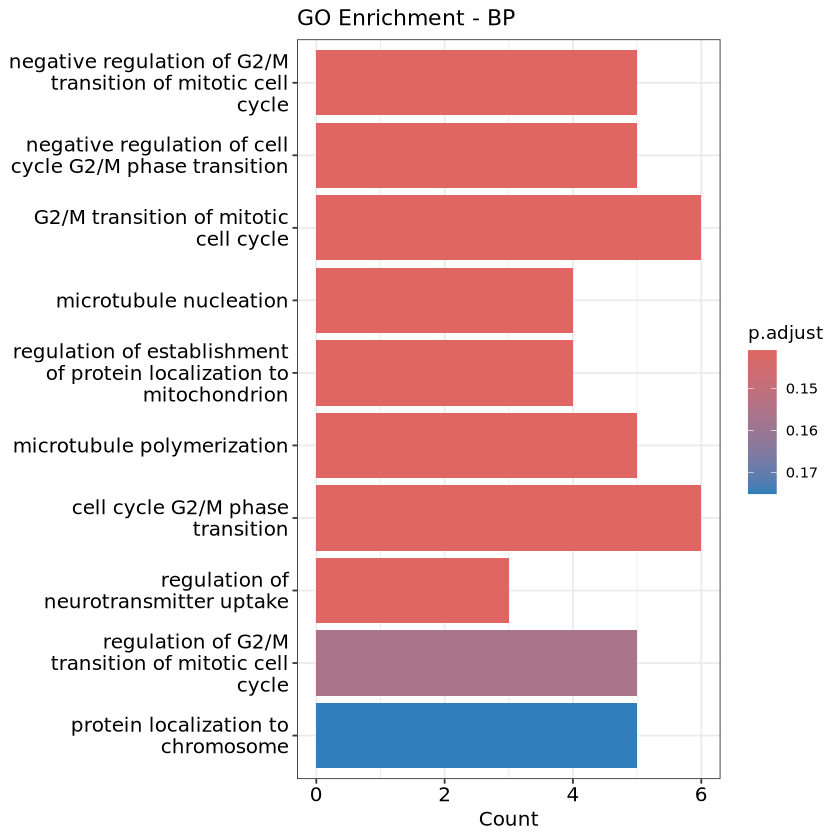

In [33]:
barplot(AD2_sig_gene_ego, showCategory = 10, title = "GO Enrichment - BP")

In [34]:
AD2_sig_gene_ego_cc <- enrichGO(
  gene          = unique(image_AD2_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "CC",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [35]:
head(AD2_sig_gene_ego_cc, n=15)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0000930,GO:0000930,gamma-tubulin complex,3/128,20/22568,0.0001893172,0.04486817,0.03866056,ENSG00000037042/ENSG00000131462/ENSG00000012048,3
GO:0031252,GO:0031252,cell leading edge,9/128,461/22568,0.0012811717,0.12154928,0.10473267,ENSG00000088992/ENSG00000186868/ENSG00000088280/ENSG00000115306/ENSG00000137312/ENSG00000131462/ENSG00000108852/ENSG00000149091/ENSG00000198561,9
GO:1902911,GO:1902911,protein kinase complex,5/128,174/22568,0.0031730575,0.12154928,0.10473267,ENSG00000183735/ENSG00000136560/ENSG00000115592/ENSG00000204435/ENSG00000175224,5
GO:0001741,GO:0001741,XY body,2/128,16/22568,0.0036359456,0.12154928,0.10473267,ENSG00000143194/ENSG00000012048,2
GO:0043505,GO:0043505,CENP-A containing nucleosome,2/128,18/22568,0.0046015997,0.12154928,0.10473267,ENSG00000278463/ENSG00000275126,2
GO:0061638,GO:0061638,CENP-A containing chromatin,2/128,18/22568,0.0046015997,0.12154928,0.10473267,ENSG00000278463/ENSG00000275126,2
GO:0032279,GO:0032279,asymmetric synapse,7/128,363/22568,0.0047220545,0.12154928,0.10473267,ENSG00000089250/ENSG00000115306/ENSG00000108852/ENSG00000131094/ENSG00000073969/ENSG00000134569/ENSG00000198561,7
GO:0000775,GO:0000775,"chromosome, centromeric region",6/128,277/22568,0.0050476233,0.12154928,0.10473267,ENSG00000278463/ENSG00000120071/ENSG00000275126/ENSG00000254093/ENSG00000258724/ENSG00000175216,6
GO:0034506,GO:0034506,"chromosome, centromeric core domain",2/128,20/22568,0.0056722470,0.12154928,0.10473267,ENSG00000278463/ENSG00000275126,2


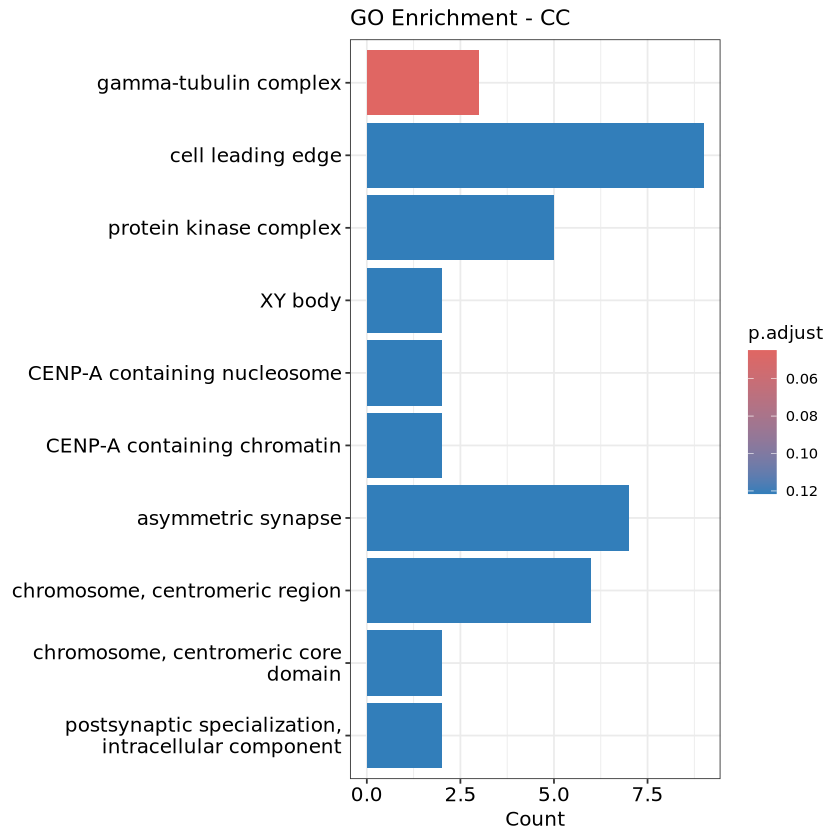

In [36]:
barplot(AD2_sig_gene_ego_cc, showCategory = 10, title = "GO Enrichment - CC")

In [37]:
image_AD2_sig_gene_ego_mf <- enrichGO(
  gene          = unique(image_AD2_gene$gene_id),
  OrgDb         = org.Hs.eg.db,
  keyType       = "ENSEMBL",
  ont           = "MF",
  pAdjustMethod = "BH",
  pvalueCutoff  = 1,
  qvalueCutoff  = 1
)


In [38]:
head(image_AD2_sig_gene_ego_mf, n=10)

,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
GO:0016667,GO:0016667,"oxidoreductase activity, acting on a sulfur group of donors",3/125,60/21059,0.005460618,0.3851329,0.3709673,ENSG00000174099/ENSG00000086619/ENSG00000213593,3
GO:0005200,GO:0005200,structural constituent of cytoskeleton,4/125,129/21059,0.007363744,0.3851329,0.3709673,ENSG00000115306/ENSG00000037042/ENSG00000131462/ENSG00000131095,4
GO:0034185,GO:0034185,apolipoprotein binding,2/125,23/21059,0.008150324,0.3851329,0.3709673,ENSG00000186868/ENSG00000134569,2
GO:0070034,GO:0070034,telomerase RNA binding,2/125,28/21059,0.011944362,0.3851329,0.3709673,ENSG00000254093/ENSG00000258724,2
GO:0019902,GO:0019902,phosphatase binding,5/125,230/21059,0.012113209,0.3851329,0.3709673,ENSG00000102882/ENSG00000186868/ENSG00000183735/ENSG00000146112/ENSG00000132842,5
GO:0004435,GO:0004435,phosphatidylinositol phospholipase C activity,2/125,29/21059,0.012779767,0.3851329,0.3709673,ENSG00000115556/ENSG00000161714,2
GO:0004629,GO:0004629,phospholipase C activity,2/125,32/21059,0.015433360,0.3851329,0.3709673,ENSG00000115556/ENSG00000161714,2
GO:0019887,GO:0019887,protein kinase regulator activity,5/125,249/21059,0.016552064,0.3851329,0.3709673,ENSG00000088992/ENSG00000186834/ENSG00000115592/ENSG00000204435/ENSG00000175224,5
GO:0035255,GO:0035255,ionotropic glutamate receptor binding,2/125,35/21059,0.018301422,0.3851329,0.3709673,ENSG00000137312/ENSG00000073969,2


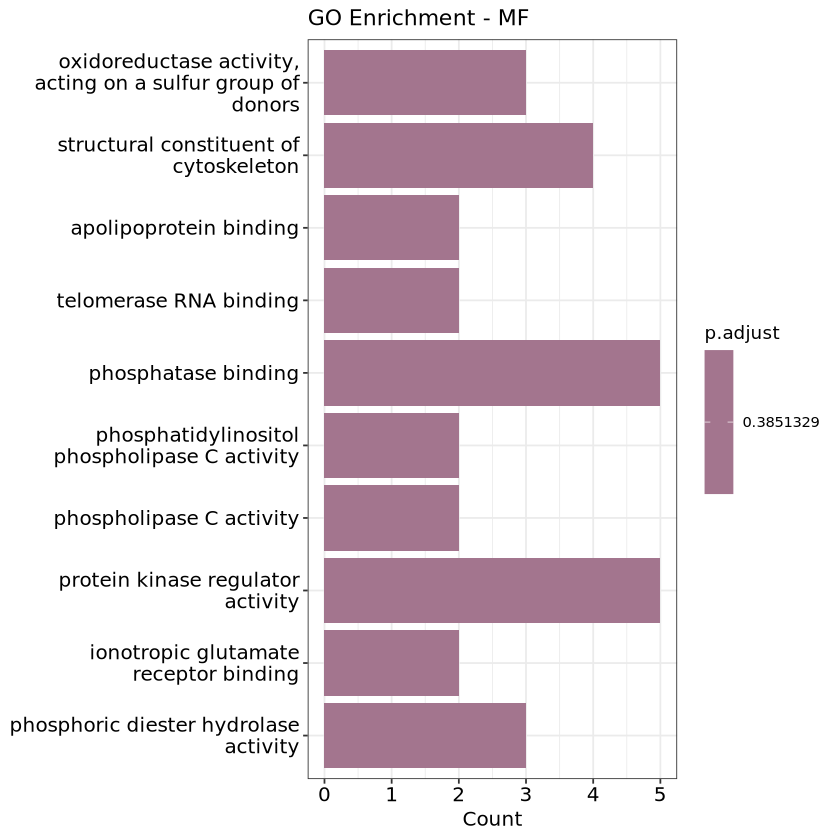

In [39]:
barplot(image_AD2_sig_gene_ego_mf, showCategory = 10, title = "GO Enrichment - MF")

In [40]:
entrez_ids <- bitr(image_AD2_gene$gene_id, fromType = "ENSEMBL", 
                   toType = "ENTREZID", OrgDb = org.Hs.eg.db)

kegg_enrich <- enrichKEGG(gene         = entrez_ids$ENTREZID,
                          organism     = 'hsa',
                          pvalueCutoff = 1,
                         qvalueCutoff = 1)

'select()' returned 1:many mapping between keys and columns

Warning message in bitr(image_AD2_gene$gene_id, fromType = "ENSEMBL", toType = "ENTREZID", :
“2.21% of input gene IDs are fail to map...”
Reading KEGG annotation online: "https://rest.kegg.jp/link/hsa/pathway"...

Reading KEGG annotation online: "https://rest.kegg.jp/list/pathway/hsa"...



In [41]:
kegg_enrich %>% head(n=20)

,category,subcategory,ID,Description,GeneRatio,BgRatio,pvalue,p.adjust,qvalue,geneID,Count
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
hsa05133,Human Diseases,Infectious disease: bacterial,hsa05133,Pertussis,5/58,78/9446,0.0001097923,0.01676827,0.01505756,5595/721/720/110384692/51561,5
hsa04936,Human Diseases,Endocrine and metabolic disease,hsa04936,Alcoholic liver disease,6/58,144/9446,0.0002384114,0.01676827,0.01505756,721/720/110384692/29110/9020/53632,6
hsa05322,Human Diseases,Immune disease,hsa05322,Systemic lupus erythematosus,6/58,144/9446,0.0002384114,0.01676827,0.01505756,8335/721/720/110384692/8368/8969,6
hsa04520,Cellular Processes,Cellular community - eukaryotes,hsa04520,Adherens junction,4/58,93/9446,0.0024894184,0.11580739,0.10399266,5595/1460/83605/1500,4
hsa05171,Human Diseases,Infectious disease: viral,hsa05171,Coronavirus disease - COVID-19,6/58,238/9446,0.0032531460,0.11580739,0.10399266,5595/721/720/110384692/29110/6773,6
hsa04140,Cellular Processes,Transport and catabolism,hsa04140,Autophagy - animal,5/58,169/9446,0.0036835574,0.11580739,0.10399266,5595/29110/10010/9842/9776,5
hsa04625,Organismal Systems,Immune system,hsa04625,C-type lectin receptor signaling pathway,4/58,105/9446,0.0038598159,0.11580739,0.10399266,5595/9020/51561/6773,4
hsa05131,Human Diseases,Infectious disease: bacterial,hsa05131,Shigellosis,6/58,253/9446,0.0043908014,0.11580739,0.10399266,5595/84812/29110/113026/7323/10318,6
hsa04730,Organismal Systems,Nervous system,hsa04730,Long-term depression,3/58,60/9446,0.0058674012,0.13030469,0.11701095,4842/5595/1394,3


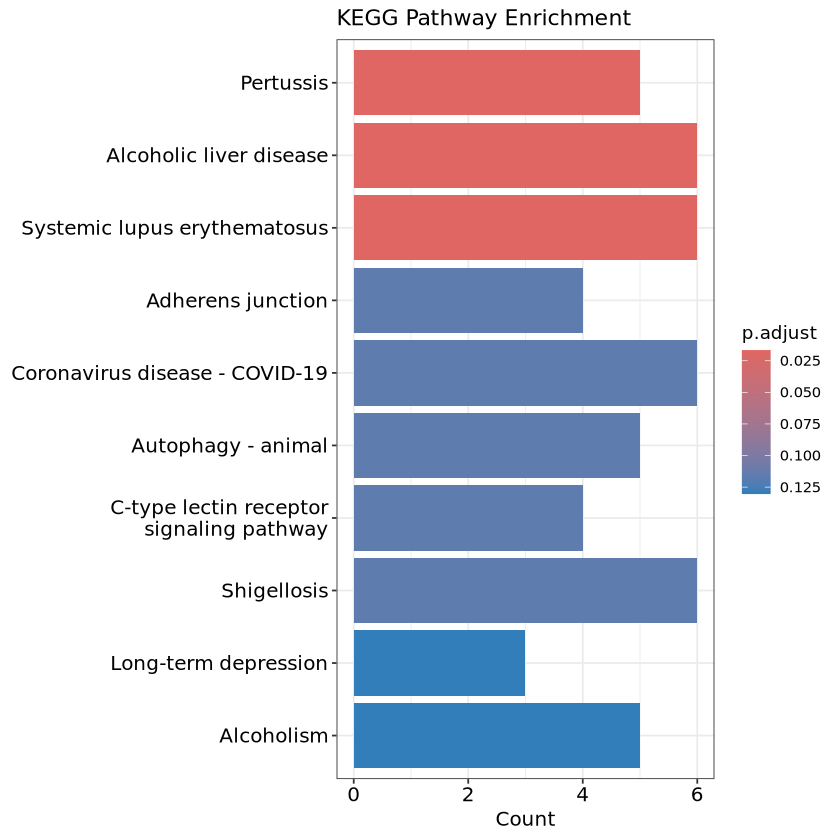

In [42]:
barplot(kegg_enrich, showCategory = 10, title = "KEGG Pathway Enrichment")